In [57]:
import pandas as pd
import numpy as np
import os
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.stattools import acf
from datetime import datetime, timedelta

from math import sqrt
from scipy.stats import norm

import sys
sys.path.append(r'C:\Users\wilfe\Local_files\Python\Eafit\v-logistics\funciones_pronosticos')  # Especifica la carpeta donde está funciones_pronostico.py
import funciones_pronosticos as fp

import ipywidgets as widgets
from IPython.display import display
from io import StringIO

# Carga de datos

In [123]:
# Define la carpeta donde están los archivos
folder_path = 'dataset/'

# Lista para almacenar cada DataFrame
dataframes = []

# Itera sobre cada archivo en la carpeta
for filename in os.listdir(folder_path):
    if filename.endswith('2025.csv'):
        # Extrae "Producto" y "Regional" del nombre del archivo
        regional, año = filename.split('_')
        año = año.replace('.csv', '')
        
        # Carga el archivo y añade las columnas "Producto" y "Regional"
        df = pd.read_csv(os.path.join(folder_path, filename))
        df['REGIONAL'] = regional
        print(f'Ultimo turno {regional}:',df['Turn'].max())
        # Agrega el DataFrame a la lista
        dataframes.append(df)

# Concatena todos los DataFrames en uno solo
df_final = pd.concat(dataframes, ignore_index=True)
df_final.columns = df_final.columns.str.replace(r"\s*\(Product\)", "", regex=True).str.strip()
df_final['REGIONAL'] = df_final['REGIONAL'].str.upper()

# Mostar df
df_final

Ultimo turno centro: 0
Ultimo turno norte: 0
Ultimo turno sur: 0


,Turn,MOTO,CUATRIMOTO,TRACTOR,REGIONAL
0,-207,14,2,7.0,CENTRO
1,-206,13,9,7.0,CENTRO
2,-205,10,7,12.0,CENTRO
3,-204,7,7,11.0,CENTRO
4,-203,20,5,11.0,CENTRO
...,...,...,...,...,...
619,-4,16,5,NaN,SUR
620,-3,19,9,NaN,SUR
621,-2,15,10,NaN,SUR
622,-1,21,10,NaN,SUR


In [124]:
# Productos a considerar
productos = ['MOTO', 'CUATRIMOTO', 'TRACTOR']

# 1. Crear CEDI: CENTRO + SUR
df_cedi = df_final[df_final['REGIONAL'].isin(['CENTRO', 'SUR'])].groupby('Turn')[productos].sum().reset_index()
df_cedi['REGIONAL'] = 'CEDI'

# 2. Crear MOTOTRAK: NORTE + CENTRO + SUR
df_mototrak = df_final[df_final['REGIONAL'].isin(['NORTE', 'CENTRO', 'SUR'])].groupby('Turn')[productos].sum().reset_index()
df_mototrak['REGIONAL'] = 'MOTOTRAK'

# 3. Concatenar todo
df_final = pd.concat([df_final, df_cedi, df_mototrak], ignore_index=True)

# (Opcional) Ordenar si lo deseas
df_final = df_final.sort_values(by=['REGIONAL', 'Turn']).reset_index(drop=True)


df_final

,Turn,MOTO,CUATRIMOTO,TRACTOR,REGIONAL
0,-207,28,5,7.0,CEDI
1,-206,29,16,7.0,CEDI
2,-205,21,18,12.0,CEDI
3,-204,20,14,11.0,CEDI
4,-203,31,23,11.0,CEDI
...,...,...,...,...,...
1035,-4,16,5,NaN,SUR
1036,-3,19,9,NaN,SUR
1037,-2,15,10,NaN,SUR
1038,-1,21,10,NaN,SUR


In [125]:
# Transformar el DataFrame utilizando pd.melt
df = pd.melt(
    df_final, 
    id_vars=['Turn', 'REGIONAL'],  # Columnas que permanecen fijas
    value_vars=['MOTO', 'CUATRIMOTO', 'TRACTOR'],  # Columnas que se convertirán en filas
    var_name='PRODUCTO',  # Nombre para la nueva columna de productos
    value_name='DEMANDA'  # Nombre para la nueva columna de valores
)

# Eliminar filas con DEMANDA nula (Tractor en Sur)
df = df.dropna(subset='DEMANDA').reset_index(drop=True)

# Visualizar el resultado
df

,Turn,REGIONAL,PRODUCTO,DEMANDA
0,-207,CEDI,MOTO,28.0
1,-206,CEDI,MOTO,29.0
2,-205,CEDI,MOTO,21.0
3,-204,CEDI,MOTO,20.0
4,-203,CEDI,MOTO,31.0
...,...,...,...,...
2907,-4,NORTE,TRACTOR,5.0
2908,-3,NORTE,TRACTOR,2.0
2909,-2,NORTE,TRACTOR,2.0
2910,-1,NORTE,TRACTOR,3.0


# Graficas de demanda

In [126]:
# Productos y colores
productos = ['MOTO', 'CUATRIMOTO', 'TRACTOR']
colores = {
    'MOTO': 'salmon',
    'CUATRIMOTO': 'navy',
    'TRACTOR': 'darkcyan'
}

# Regionales para graficar directamente desde df (ya están agregadas)
regionales = ['NORTE', 'CENTRO', 'SUR', 'CEDI', 'MOTOTRAK']

# Crear figura 2x3
fig = make_subplots(
    rows=2, cols=3, 
    subplot_titles=["NORTE", "CENTRO", "SUR", "CEDI (C+S)", "MOTOTRAK (N+C+S)", ""]
)

# Mapeo a subplot
subplot_pos = {
    'NORTE': (1, 1),
    'CENTRO': (1, 2),
    'SUR': (1, 3),
    'CEDI': (2, 1),
    'MOTOTRAK': (2, 2)
}

# Mostrar leyenda solo en el primer subplot
showlegend_flag = True

# Trazar por cada regional
for region in regionales:
    row, col = subplot_pos[region]
    df_region = df[df['REGIONAL'] == region]
    for producto in productos:
        df_sub = df_region[df_region['PRODUCTO'] == producto]
        if not df_sub.empty:
            fig.add_trace(
                go.Scatter(
                    x=df_sub['Turn'], 
                    y=df_sub['DEMANDA'], 
                    mode='lines',
                    name=producto,
                    line=dict(color=colores[producto]),
                    showlegend=showlegend_flag
                ),
                row=row, col=col
            )
    showlegend_flag = False  # Solo en el primer gráfico

# Layout
fig.update_layout(
    height=700, width=1200,
    title_text="Demanda por Regional y Agregados",
    showlegend=True,
    legend_title="Producto",
    template="ggplot2"
)

# Etiquetas comunes
fig.update_xaxes(title_text="Turn", row=2, col=1)
fig.update_xaxes(title_text="Turn", row=2, col=2)
fig.update_yaxes(title_text="Demanda", row=1, col=1)
fig.update_yaxes(title_text="Demanda", row=2, col=1)

# Mostrar gráfico
fig.show()

# Resumenes Estadisticos

In [127]:
# Crear una tabla resumen por cada regional
for regional in regionales:
    df_regional = df[df['REGIONAL'] == regional]
    
    # Agrupar por producto y describir la DEMANDA, luego redondear
    resumen = df_regional.groupby('PRODUCTO')['DEMANDA'].describe().round(1)
    
    # Mostrar
    display(f"Resumen estadístico para {regional}", resumen)

'Resumen estadístico para NORTE'

,count,mean,std,min,25%,50%,75%,max
PRODUCTO,,,,,,,,
CUATRIMOTO,208.0,7.1,3.0,0.0,5.0,7.0,9.0,16.0
MOTO,208.0,11.2,3.7,2.0,8.0,11.0,14.0,20.0
TRACTOR,208.0,3.5,1.8,0.0,2.0,3.0,5.0,9.0


'Resumen estadístico para CENTRO'

,count,mean,std,min,25%,50%,75%,max
PRODUCTO,,,,,,,,
CUATRIMOTO,208.0,10.0,2.5,2.0,8.0,10.0,12.0,15.0
MOTO,208.0,18.4,4.9,1.0,15.0,18.5,22.0,30.0
TRACTOR,208.0,9.8,3.8,0.0,7.0,10.0,12.0,22.0


'Resumen estadístico para SUR'

,count,mean,std,min,25%,50%,75%,max
PRODUCTO,,,,,,,,
CUATRIMOTO,208.0,9.3,2.8,1.0,8.0,9.0,11.0,18.0
MOTO,208.0,15.1,3.2,7.0,13.0,15.0,17.0,23.0


'Resumen estadístico para CEDI'

,count,mean,std,min,25%,50%,75%,max
PRODUCTO,,,,,,,,
CUATRIMOTO,208.0,19.3,3.7,5.0,16.0,19.5,22.0,27.0
MOTO,208.0,33.5,7.1,16.0,29.0,33.0,39.0,51.0
TRACTOR,208.0,9.8,3.8,0.0,7.0,10.0,12.0,22.0


'Resumen estadístico para MOTOTRAK'

,count,mean,std,min,25%,50%,75%,max
PRODUCTO,,,,,,,,
CUATRIMOTO,208.0,26.4,5.1,11.0,23.0,27.0,30.0,39.0
MOTO,208.0,44.7,10.1,20.0,38.0,44.0,52.0,69.0
TRACTOR,208.0,13.3,4.3,3.0,10.0,13.0,16.0,26.0


# Evaluacion y generacion de pronósticos de Producto terminado

## Diccionario para almacenar cada serie de tiempo

In [128]:
series_dict = {
    (reg, prod): serie
    for reg in df['REGIONAL'].unique()
    for prod in df['PRODUCTO'].unique()
    if not (serie := df[(df['REGIONAL'] == reg) & (df['PRODUCTO'] == prod)]
                  .set_index('Turn')['DEMANDA']
                  .sort_index()).empty
}

## Rango de Fechas para el backtesting
Se hará backtesting desde el periodo -24 hasta el -1, generando 18 pronósticos hacia adelante (18 lags).

In [159]:
# Definir el rango de periodos y lags
periodos_atras = 24
lags = 6

# Obtener los valores de índice de una serie cualquiera
turnos = next(iter(series_dict.values())).index.tolist()

# Filtrar los valores del índice entre -24 y 0 
rango_turnos = turnos[-(periodos_atras+1):]

In [160]:
resultados_por_serie = {}

for (regional, producto), serie in series_dict.items():
    print(f"▶ Analizando {regional} - {producto}")

    # Obtener los índices de corte
    #turnos = serie.index.tolist()
    #rango_turnos = turnos[-periodos_atras:]
    #lags = 18

    # Para guardar pronósticos válidos
    resultados_hw, resultados_hw_13 = [], []
    resultados_pm_3, resultados_pm_6, resultados_pm_12 = [], [], []

    for i, fecha_corte in enumerate(rango_turnos):
        serie_corte = serie[serie.index <= fecha_corte]
        indice_real = serie_corte.index
        serie_corte.index = pd.RangeIndex(start=0, stop=len(serie_corte))

        inicio_pronostico = fecha_corte + 1
        fin_pronostico = inicio_pronostico + lags - 1

        if len(serie_corte) >= 10:
            modelo_hw = ExponentialSmoothing(serie_corte, trend='add', seasonal=None).fit()
            forecast_hw = modelo_hw.forecast(lags)
            forecast_hw.index = range(inicio_pronostico, fin_pronostico + 1)

            modelo_hw_13 = ExponentialSmoothing(serie_corte, trend='add', seasonal='add', seasonal_periods=13).fit()
            forecast_hw_13 = modelo_hw_13.forecast(lags)
            forecast_hw_13.index = range(inicio_pronostico, fin_pronostico + 1)
        else:
            forecast_hw = pd.Series([np.nan] * lags, index=range(inicio_pronostico, fin_pronostico + 1))
            forecast_hw_13 = pd.Series([np.nan] * lags, index=range(inicio_pronostico, fin_pronostico + 1))

        serie_corte.index = indice_real
        pm_3 = serie_corte.rolling(3).mean().iloc[-1] if len(serie_corte) >= 3 else np.nan
        pm_6 = serie_corte.rolling(6).mean().iloc[-1] if len(serie_corte) >= 6 else np.nan
        pm_12 = serie_corte.rolling(12).mean().iloc[-1] if len(serie_corte) >= 12 else np.nan

        pm_3_series = pd.Series([pm_3] * lags, index=range(inicio_pronostico, fin_pronostico + 1))
        pm_6_series = pd.Series([pm_6] * lags, index=range(inicio_pronostico, fin_pronostico + 1))
        pm_12_series = pd.Series([pm_12] * lags, index=range(inicio_pronostico, fin_pronostico + 1))

        demanda_real = serie.loc[inicio_pronostico:fin_pronostico]

        df_comb = pd.DataFrame({
            'real': demanda_real,
            'hw': forecast_hw,
            'hw_13': forecast_hw_13,
            'pm_3': pm_3_series,
            'pm_6': pm_6_series,
            'pm_12': pm_12_series,
        })

        if i < len(rango_turnos) - 1:
            df_comb = df_comb.dropna(subset=['real'])
            resultados_hw.append(df_comb[['real', 'hw']])
            resultados_hw_13.append(df_comb[['real', 'hw_13']])
            resultados_pm_3.append(df_comb[['real', 'pm_3']])
            resultados_pm_6.append(df_comb[['real', 'pm_6']])
            resultados_pm_12.append(df_comb[['real', 'pm_12']])
        else:
            # Último pronóstico completo
            pronostico_final_hw = df_comb[['real', 'hw']]
            pronostico_final_hw_13 = df_comb[['real', 'hw_13']]
            pronostico_final_pm_3 = df_comb[['real', 'pm_3']]
            pronostico_final_pm_6 = df_comb[['real', 'pm_6']]
            pronostico_final_pm_12 = df_comb[['real', 'pm_12']]

    # Evaluar modelos
    modelos = {
        'hw': (resultados_hw, pronostico_final_hw),
        'hw_13': (resultados_hw_13, pronostico_final_hw_13),
        'pm_3': (resultados_pm_3, pronostico_final_pm_3),
        'pm_6': (resultados_pm_6, pronostico_final_pm_6),
        'pm_12': (resultados_pm_12, pronostico_final_pm_12),
    }

    metricas_modelos = {}
    for nombre_modelo, (resultados, _) in modelos.items():
        df_resultado = pd.concat(resultados)
        df_resultado["error"] = df_resultado["real"] - df_resultado[nombre_modelo]
        df_resultado["error_abs"] = df_resultado["error"].abs()
        suma_real = df_resultado["real"].sum()
        mae_porc = df_resultado["error_abs"].sum() / suma_real
        sesgo_porc = df_resultado["error"].sum() / suma_real
        score_porc = mae_porc + abs(sesgo_porc)
        rmse = np.sqrt((df_resultado["error"] ** 2).mean())
        metricas_modelos[nombre_modelo] = {
            "mae_porc": mae_porc,
            "sesgo_porc": sesgo_porc,
            "score_porc": score_porc,
            "rmse": rmse
        }

    df_metricas = pd.DataFrame(metricas_modelos).T.sort_values("score_porc")
    mejor_modelo = df_metricas.index[0]
    pronostico_final = modelos[mejor_modelo][1]

    resultados_por_serie[(regional, producto)] = {
        "mejor_modelo": mejor_modelo,
        "metricas": df_metricas,
        "pronostico_final": pronostico_final
    }

▶ Analizando CEDI - MOTO
▶ Analizando CEDI - CUATRIMOTO
▶ Analizando CEDI - TRACTOR
▶ Analizando CENTRO - MOTO
▶ Analizando CENTRO - CUATRIMOTO
▶ Analizando CENTRO - TRACTOR
▶ Analizando MOTOTRAK - MOTO
▶ Analizando MOTOTRAK - CUATRIMOTO
▶ Analizando MOTOTRAK - TRACTOR
▶ Analizando NORTE - MOTO
▶ Analizando NORTE - CUATRIMOTO
▶ Analizando NORTE - TRACTOR
▶ Analizando SUR - MOTO
▶ Analizando SUR - CUATRIMOTO


In [153]:
resultados_por_serie

{('CEDI', 'MOTO'): {'mejor_modelo': 'pm_12',
  'metricas':        mae_porc  sesgo_porc  score_porc      rmse
  pm_12  0.125151   -0.012215    0.137366  5.901400
  hw_13  0.104361   -0.039310    0.143670  4.796076
  pm_6   0.145629   -0.026326    0.171955  6.745932
  pm_3   0.156837   -0.019975    0.176812  7.256747
  hw     0.159819   -0.030969    0.190788  7.487192,
  'pronostico_final':     real  pm_12
  1    NaN  37.75
  2    NaN  37.75
  3    NaN  37.75
  4    NaN  37.75
  5    NaN  37.75
  6    NaN  37.75
  7    NaN  37.75
  8    NaN  37.75
  9    NaN  37.75
  10   NaN  37.75
  11   NaN  37.75
  12   NaN  37.75
  13   NaN  37.75
  14   NaN  37.75
  15   NaN  37.75
  16   NaN  37.75
  17   NaN  37.75
  18   NaN  37.75
  19   NaN  37.75
  20   NaN  37.75
  21   NaN  37.75
  22   NaN  37.75
  23   NaN  37.75
  24   NaN  37.75},
 ('CEDI', 'CUATRIMOTO'): {'mejor_modelo': 'hw_13',
  'metricas':        mae_porc  sesgo_porc  score_porc      rmse
  hw_13  0.149920   -0.065959    0.215879  

In [161]:
# Crear figura 2x3
fig = make_subplots(
    rows=2, cols=3,
    subplot_titles=["NORTE", "CENTRO", "SUR", "CEDI (C+S)", "MOTOTRAK (N+C+S)", ""]
)

# Posiciones de subplots
subplot_pos = {
    'NORTE': (1, 1),
    'CENTRO': (1, 2),
    'SUR': (1, 3),
    'CEDI': (2, 1),
    'MOTOTRAK': (2, 2)
}

# Mostrar leyenda solo una vez
showlegend_flag = True

# Agregar trazos de demanda real y pronóstico
for region in regionales:
    row, col = subplot_pos[region]
    df_region = df[df['REGIONAL'] == region]

    for producto in productos:
        # 1. Demanda real
        df_sub = df_region[df_region['PRODUCTO'] == producto]
        if not df_sub.empty:
            fig.add_trace(
                go.Scatter(
                    x=df_sub['Turn'],
                    y=df_sub['DEMANDA'],
                    mode='lines',
                    name=producto,
                    line=dict(color=colores[producto]),
                    showlegend=showlegend_flag
                ),
                row=row, col=col
            )

        # 2. Pronóstico (si existe en resultados)
        clave = (region, producto)
        if clave in resultados_por_serie:
            pronostico_final = resultados_por_serie[clave]["pronostico_final"]
            mejor_modelo = resultados_por_serie[clave]["mejor_modelo"]

            if not pronostico_final.empty:
                fig.add_trace(
                    go.Scatter(
                        x=pronostico_final.index,
                        y=pronostico_final[mejor_modelo],
                        mode='lines',
                        name=f"{producto} ({mejor_modelo})",
                        line=dict(dash='dot', color=colores[producto]),
                        showlegend=showlegend_flag
                    ),
                    row=row, col=col
                )

    showlegend_flag = False  # Solo mostrar en el primer subplot

# Layout final
fig.update_layout(
    height=700, width=1200,
    title_text="Demanda Real y Pronóstico por Regional y Producto",
    showlegend=True,
    legend_title="Producto / Modelo",
    template="ggplot2"
)

# Etiquetas ejes
fig.update_xaxes(title_text="Turn", row=2, col=1)
fig.update_xaxes(title_text="Turn", row=2, col=2)
fig.update_yaxes(title_text="Demanda", row=1, col=1)
fig.update_yaxes(title_text="Demanda", row=2, col=1)

fig.show()

In [162]:
# Construir DataFrame de resumen final
resumen_filas = []

for (regional, producto), datos in resultados_por_serie.items():
    mejor_modelo = datos['mejor_modelo']
    metricas = datos['metricas']
    pronostico_final = datos['pronostico_final']

    # Obtener métricas del mejor modelo
    rmse_val = metricas.loc[mejor_modelo, 'rmse']
    score_val = metricas.loc[mejor_modelo, 'score_porc']

    # Extraer pronósticos del mejor modelo
    pronostico = pronostico_final[mejor_modelo]

    # Convertir índice a columnas de pronóstico: 1, 2, ..., N
    fila = {
        'REGIONAL': regional,
        'PRODUCTO': producto,
        'MODELO': mejor_modelo.upper(),
        'SCORE_PORC': f"{round(score_val * 100, 1)}%",        
        'RMSE': round(rmse_val, 1),
    }

    for i, (turno, valor) in enumerate(pronostico.items(), start=1):
        fila[i] = round(valor, 0) if pd.notna(valor) else np.nan

    resumen_filas.append(fila)

# Crear DataFrame final
df_resumen = pd.DataFrame(resumen_filas)

# Ordenar columnas: fijas + dinámicas (1, 2, ..., N)
cols_fijas = ['REGIONAL', 'PRODUCTO', 'SCORE_PORC', 'MODELO', 'RMSE']
cols_turnos = sorted([col for col in df_resumen.columns if isinstance(col, int)])
df_resumen = df_resumen[cols_fijas + cols_turnos]

# Mostrar
from IPython.display import display
display(df_resumen)

,REGIONAL,PRODUCTO,SCORE_PORC,MODELO,RMSE,1,2,3,4,5,6
0,CEDI,MOTO,13.8%,PM_12,5.8,38.0,38.0,38.0,38.0,38.0,38.0
1,CEDI,CUATRIMOTO,19.7%,HW_13,3.7,22.0,23.0,20.0,22.0,22.0,22.0
2,CEDI,TRACTOR,26.1%,PM_6,3.4,11.0,11.0,11.0,11.0,11.0,11.0
3,CENTRO,MOTO,22.2%,PM_12,4.7,21.0,21.0,21.0,21.0,21.0,21.0
4,CENTRO,CUATRIMOTO,13.3%,PM_6,1.8,12.0,12.0,12.0,12.0,12.0,12.0
5,CENTRO,TRACTOR,26.1%,PM_6,3.4,11.0,11.0,11.0,11.0,11.0,11.0
6,MOTOTRAK,MOTO,12.7%,PM_12,7.7,53.0,53.0,53.0,53.0,53.0,53.0
7,MOTOTRAK,CUATRIMOTO,16.5%,PM_12,4.5,28.0,28.0,28.0,28.0,28.0,28.0
8,MOTOTRAK,TRACTOR,23.9%,HW,4.1,14.0,14.0,14.0,14.0,14.0,14.0
9,NORTE,MOTO,15.4%,HW_13,2.1,18.0,18.0,16.0,16.0,14.0,14.0


### Funciones de apoyo a preprocesamiento

In [12]:
# esta funcion no se puede alojar en funciones_pronosticos por que usa 'globals'
def generar_reporte_error_skus(modelos):
    return {modelo: globals()[f'grupo_sku_error_formato_{modelo}'] for modelo in modelos}

In [13]:
def concatenar_rmse(modelos):
    # Obtener los DataFrames dinámicamente usando la lista de modelos
    dfs_error = []
    
    for modelo in modelos:
        # Obtener el DataFrame para cada modelo
        df = globals().get(f'rmse_sku_mes_{modelo}')
        
        # Verificar si el DataFrame es None o está vacío
        if df is None or df.empty:
            print(f"El modelo {modelo} fue ignorado porque no tiene datos.")
            continue
        
        # Añadir una columna 'MODELO' con el nombre del modelo
        df['MODELO'] = modelo
        #f['RMSE'] = np.ceil(df['RMSE']).astype(int)
        #df['RMSE'] = df['RMSE'].astype(int)
        # Añadir el DataFrame a la lista
        dfs_error.append(df)
    
    # Verificar si hay DataFrames para concatenar
    if not dfs_error:
        print("No hay datos para concatenar.")
        return pd.DataFrame()  # Devuelve un DataFrame vacío
    
    # Concatenar todos los DataFrames en uno solo
    df_todos_rmse = pd.concat(dfs_error, ignore_index=True)
    
    # Asegurar que la columna 'CODIGO' sea de tipo string
    df_todos_rmse['PRODUCTO'] = df_todos_rmse['PRODUCTO'].astype(str)

    return df_todos_rmse

In [14]:
def concatenar_forecasts_pronosticos(modelos):
    # Filtrar los DataFrames válidos (no None y no vacíos)
    dfs_validos = [
        globals()[f'df_forecast_final_{modelo}']
        for modelo in modelos
        if globals()[f'df_forecast_final_{modelo}'] is not None and not globals()[f'df_forecast_final_{modelo}'].empty
    ]
    
    # Verificar si hay DataFrames válidos
    if not dfs_validos:
        print("No hay pronósticos válidos para concatenar.")
        return None

    # Concatenar todos los DataFrames válidos en uno solo
    df_todos_pronosticos = pd.concat(dfs_validos)

    # Asegurar que la columna 'PRODUCTO' sea de tipo string
    df_todos_pronosticos['PRODUCTO'] = df_todos_pronosticos['PRODUCTO'].astype(str)

    return df_todos_pronosticos

In [15]:
df_total = pd.concat([df, df_agregado])

### Simulacion para pronosticos producto terminado por regional

Advertencia: La serie para TRACTOR, sur contiene valores NaN. No se pronosticará.
Errores Modelo Holt Winters:
Periodo de Evaluacion desde:
-34 hasta 0
MAE% modelo: 13.84%
Sesgo% modelo: 0.94%
Score modelo: 14.78%
RMSE modelo: 3.4


,PRODUCTO,REGIONAL,MAE%,SESGO%,SCORE%
5,MOTO,mototrak,6.82%,0.17%,6.99%
7,MOTO,sur,7.63%,-0.90%,8.53%
6,MOTO,norte,7.44%,1.47%,8.91%
0,CUATRIMOTO,centro,11.15%,-1.84%,12.98%
1,CUATRIMOTO,mototrak,13.68%,-0.36%,14.04%
4,MOTO,centro,15.14%,-0.36%,15.50%
3,CUATRIMOTO,sur,23.64%,-4.66%,28.30%
9,TRACTOR,mototrak,21.78%,7.56%,29.33%
8,TRACTOR,centro,24.74%,8.10%,32.83%
2,CUATRIMOTO,norte,35.86%,5.08%,40.93%


Periodo de Evaluacion desde:
-34 hasta 0
MAE% modelo: 13.84%
Sesgo% modelo: 0.94%
Score modelo: 14.78%
RMSE modelo: 3.4


,LAG,MAE%,SESGO%,SCORE%
0,1,13.83%,0.92%,14.75%
1,2,13.76%,1.06%,14.82%
2,3,13.87%,0.97%,14.83%
3,4,13.91%,0.82%,14.73%


Advertencia: La serie para TRACTOR, sur contiene valores NaN. No se pronosticará.
Advertencia: La serie para TRACTOR, sur contiene valores NaN. No se pronosticará.
Errores Modelo Suavización Exponencial:
Periodo de Evaluacion desde:
-34 hasta 0
MAE% modelo: 17.38%
Sesgo% modelo: 3.16%
Score modelo: 20.54%
RMSE modelo: 4.4


,PRODUCTO,REGIONAL,MAE%,SESGO%,SCORE%
0,CUATRIMOTO,centro,11.67%,2.10%,13.77%
5,MOTO,mototrak,13.56%,2.19%,15.76%
1,CUATRIMOTO,mototrak,14.01%,3.25%,17.26%
7,MOTO,sur,15.47%,2.28%,17.75%
6,MOTO,norte,15.84%,3.32%,19.16%
4,MOTO,centro,17.02%,3.20%,20.21%
9,TRACTOR,mototrak,20.00%,3.11%,23.11%
3,CUATRIMOTO,sur,23.81%,-1.67%,25.48%
8,TRACTOR,centro,25.49%,5.85%,31.33%
2,CUATRIMOTO,norte,36.34%,9.59%,45.93%


Periodo de Evaluacion desde:
-34 hasta 0
MAE% modelo: 17.38%
Sesgo% modelo: 3.16%
Score modelo: 20.54%
RMSE modelo: 4.4


,LAG,MAE%,SESGO%,SCORE%
0,1,15.31%,2.37%,17.68%
1,2,16.57%,3.00%,19.56%
2,3,18.22%,3.42%,21.64%
3,4,19.59%,3.92%,23.51%


Advertencia: La serie para TRACTOR, sur contiene valores NaN. No se pronosticará.
Errores Modelo Promedio Móvil Simple:
Advertencia: La serie para TRACTOR, sur contiene valores NaN. No se pronosticará.
Periodo de Evaluacion desde:
-34 hasta 0
MAE% modelo: 17.99%
Sesgo% modelo: 2.13%
Score modelo: 20.12%
RMSE modelo: 4.6


,PRODUCTO,REGIONAL,MAE%,SESGO%,SCORE%
0,CUATRIMOTO,centro,11.08%,1.90%,12.98%
7,MOTO,sur,14.74%,-2.24%,16.98%
5,MOTO,mototrak,15.21%,2.51%,17.72%
1,CUATRIMOTO,mototrak,14.86%,3.12%,17.98%
4,MOTO,centro,16.79%,1.87%,18.66%
6,MOTO,norte,16.88%,3.51%,20.39%
9,TRACTOR,mototrak,19.78%,2.00%,21.78%
3,CUATRIMOTO,sur,23.46%,1.85%,25.31%
8,TRACTOR,centro,25.26%,3.82%,29.09%
2,CUATRIMOTO,norte,38.28%,4.59%,42.87%


Periodo de Evaluacion desde:
-34 hasta 0
MAE% modelo: 17.99%
Sesgo% modelo: 2.13%
Score modelo: 20.12%
RMSE modelo: 4.6


,LAG,MAE%,SESGO%,SCORE%
0,1,16.26%,1.43%,17.68%
1,2,17.48%,2.00%,19.48%
2,3,18.68%,2.38%,21.05%
3,4,19.69%,2.79%,22.47%


Advertencia: La serie para TRACTOR, sur contiene valores NaN. No se pronosticará.


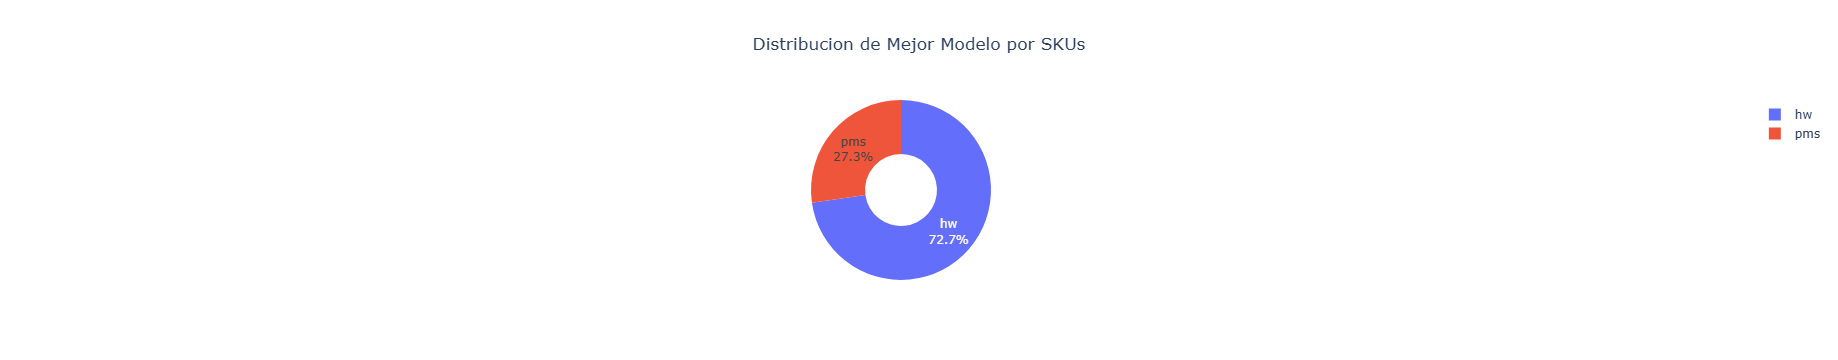

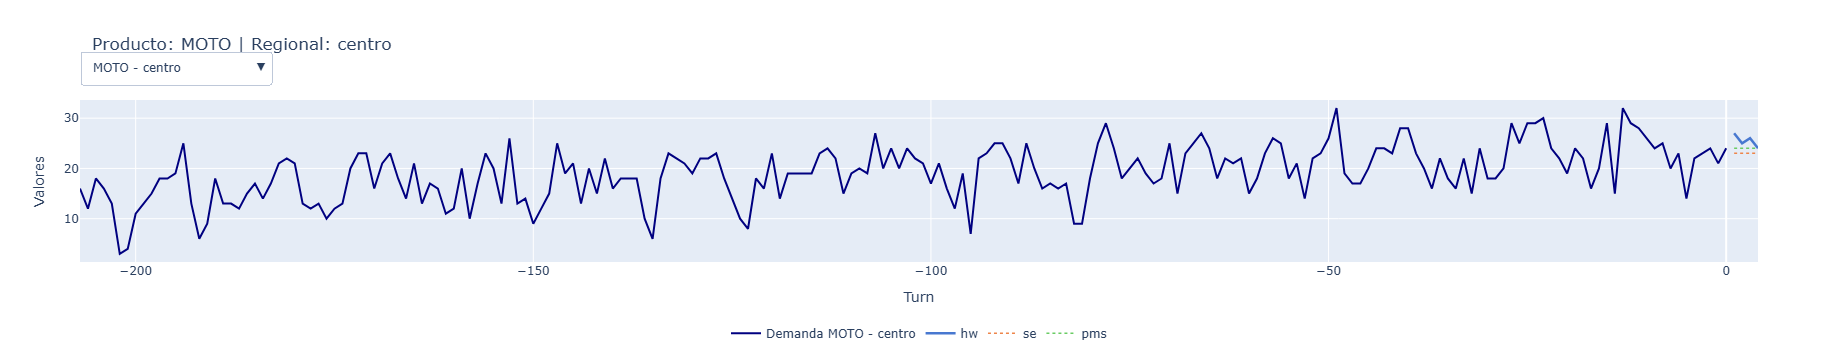

In [17]:
lags = 4
ciclos_por_año = 4
productos = df_total['PRODUCTO'].unique()
regionales = df_total['REGIONAL'].unique()

# Holt Winters
df_forecast_hw = fp.aplicar_hw(df_total, productos, regionales, lags, ciclos_por_año, pronostico_final=0)
print('\033[1mErrores Modelo Holt Winters:\033[0m')
grupo_sku_error_formato_hw, rmse_sku_lag_hw, rmse_sku_mes_hw = fp.kpi_error_sku(df_forecast_hw)
grupo_mes_error_formato_hw, df_test_hw = fp.kpi_error_lag(df_forecast_hw)
df_forecast_final_hw = fp.aplicar_hw(df_total, productos, regionales, lags, ciclos_por_año, pronostico_final=1)
df_forecast_final_hw = fp.adicionar_nombre_modelo_serie_tiempo(df_forecast_final_hw, 'hw')
df_mejor_hw = fp.agrupar_por_producto(df_forecast_hw)

# Suavizacion Exponencial
df_forecast_se = fp.aplicar_se(df_total, productos, regionales, lags, pronostico_final=0)
print('\033[1mErrores Modelo Suavización Exponencial:\033[0m')
grupo_sku_error_formato_se, rmse_sku_lag_se, rmse_sku_mes_se = fp.kpi_error_sku(df_forecast_se)
grupo_mes_error_formato_se, df_test_se = fp.kpi_error_lag(df_forecast_se)
df_forecast_final_se = fp.aplicar_se(df_total, productos, regionales, lags, pronostico_final=1)
df_forecast_final_se = fp.adicionar_nombre_modelo_serie_tiempo(df_forecast_final_se, 'se')
df_mejor_se = fp.agrupar_por_producto(df_forecast_se)

# PMS
print('\033[1mErrores Modelo Promedio Móvil Simple:\033[0m')
df_forecast_pms = fp.aplicar_pms(df_total, productos, regionales, lags, pronostico_final=0)
grupo_sku_error_formato_pms, rmse_sku_lag_pms, rmse_sku_mes_pms = fp.kpi_error_sku(df_forecast_pms)
grupo_mes_error_formato_pms, df_test_pms = fp.kpi_error_lag(df_forecast_pms)
df_forecast_final_pms = fp.aplicar_pms(df_total, productos, regionales, lags, pronostico_final=1)
df_forecast_final_pms = fp.adicionar_nombre_modelo_serie_tiempo(df_forecast_final_pms, 'pms')
df_mejor_pms = fp.agrupar_por_producto(df_forecast_pms)

# Comparacion modelos
modelos = ['hw','se','pms']
reporte_error_skus = generar_reporte_error_skus(modelos) # se ejecuta desde el mismo cuaderno
df_todos_rmse = concatenar_rmse(modelos)# se ejecuta desde el mismo cuaderno
df_minimos, df_reporte_final, reporte_error_skus, fig1, df_errores_totales = fp.comparar_y_graficar_modelos(reporte_error_skus)
fig1.show()
df_todos_pronosticos = concatenar_forecasts_pronosticos(modelos)# se ejecuta desde el mismo cuaderno

# Crear tabla final con pronosticos 
df_pronosticos_mejor_modelo, df_pronosticos_n_periodos = fp.obtener_mejor_pronostico(df_minimos, df_todos_pronosticos, df_errores_totales, df_todos_rmse)

mejores_modelos = df_pronosticos_mejor_modelo[['PRODUCTO','REGIONAL', 'MODELO']].drop_duplicates()

# Creacion de tabla de errores RMSE
rmse_ss = df_todos_rmse.merge(
    mejores_modelos,
    on=["PRODUCTO", "REGIONAL", "MODELO"],
    how="inner"  # Solo conservar las coincidencias
)
# Grafica final demanda vs mejor pronostico
fig = fp.crear_grafica_pronostico(df_total, df_todos_pronosticos, df_pronosticos_mejor_modelo)
fig.show()


## Pronósticos para la demanda atendida por el cedi (centro y sur)

In [18]:
regionales_cedi = ['centro','sur']
df_agregado_cedi = df_final[df_final['REGIONAL'].isin(regionales_cedi)].groupby('Turn')[productos].sum().reset_index()
df_agregado_cedi['REGIONAL'] = 'cedi'
# Transformar el DataFrame utilizando pd.melt
df_cedi = pd.melt(
    df_agregado_cedi, 
    id_vars=['Turn', 'REGIONAL'],  # Columnas que permanecen fijas
    value_vars=['MOTO', 'CUATRIMOTO', 'TRACTOR'],  # Columnas que se convertirán en filas
    var_name='PRODUCTO',  # Nombre para la nueva columna de productos
    value_name='DEMANDA'  # Nombre para la nueva columna de valores
)


Errores Modelo Holt Winters:
Periodo de Evaluacion desde:
-34 hasta 0
MAE% modelo: 12.54%
Sesgo% modelo: 0.05%
Score modelo: 12.60%
RMSE modelo: 3.7


,PRODUCTO,REGIONAL,MAE%,SESGO%,SCORE%
1,MOTO,cedi,8.45%,-0.33%,8.79%
0,CUATRIMOTO,cedi,14.76%,-3.19%,17.95%
2,TRACTOR,cedi,24.74%,8.10%,32.83%


Periodo de Evaluacion desde:
-34 hasta 0
MAE% modelo: 12.54%
Sesgo% modelo: 0.05%
Score modelo: 12.60%
RMSE modelo: 3.7


,LAG,MAE%,SESGO%,SCORE%
0,1,12.69%,0.20%,12.89%
1,2,12.27%,0.13%,12.40%
2,3,12.54%,0.04%,12.59%
3,4,12.67%,-0.18%,12.85%


Errores Modelo Suavización Exponencial:
Periodo de Evaluacion desde:
-34 hasta 0
MAE% modelo: 15.91%
Sesgo% modelo: 1.74%
Score modelo: 17.65%
RMSE modelo: 5.0


,PRODUCTO,REGIONAL,MAE%,SESGO%,SCORE%
0,CUATRIMOTO,cedi,13.93%,-0.34%,14.27%
1,MOTO,cedi,14.53%,1.75%,16.28%
2,TRACTOR,cedi,25.49%,5.85%,31.33%


Periodo de Evaluacion desde:
-34 hasta 0
MAE% modelo: 15.91%
Sesgo% modelo: 1.74%
Score modelo: 17.65%
RMSE modelo: 5.0


,LAG,MAE%,SESGO%,SCORE%
0,1,13.63%,1.22%,14.85%
1,2,14.66%,1.59%,16.25%
2,3,16.90%,1.90%,18.79%
3,4,18.70%,2.30%,21.00%


Errores Modelo Promedio Móvil Simple:
Periodo de Evaluacion desde:
-34 hasta 0
MAE% modelo: 16.53%
Sesgo% modelo: 2.23%
Score modelo: 18.76%
RMSE modelo: 5.2


,PRODUCTO,REGIONAL,MAE%,SESGO%,SCORE%
0,CUATRIMOTO,cedi,13.93%,1.54%,15.47%
1,MOTO,cedi,15.65%,2.18%,17.83%
2,TRACTOR,cedi,25.26%,3.82%,29.09%


Periodo de Evaluacion desde:
-34 hasta 0
MAE% modelo: 16.53%
Sesgo% modelo: 2.23%
Score modelo: 18.76%
RMSE modelo: 5.2


,LAG,MAE%,SESGO%,SCORE%
0,1,13.75%,1.67%,15.42%
1,2,15.67%,2.18%,17.85%
2,3,17.97%,2.46%,20.43%
3,4,18.96%,2.66%,21.62%


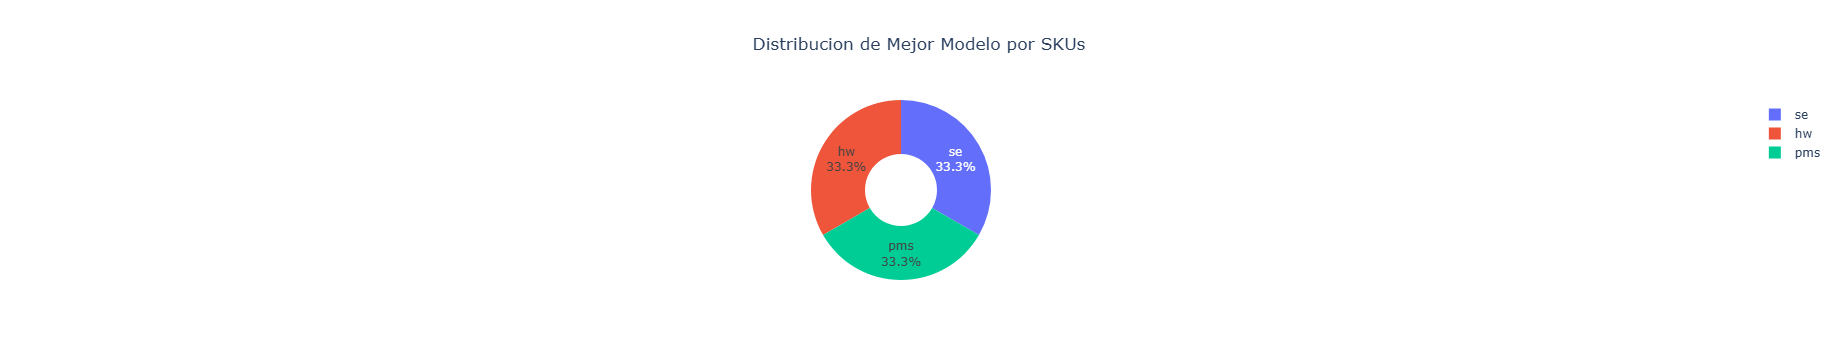

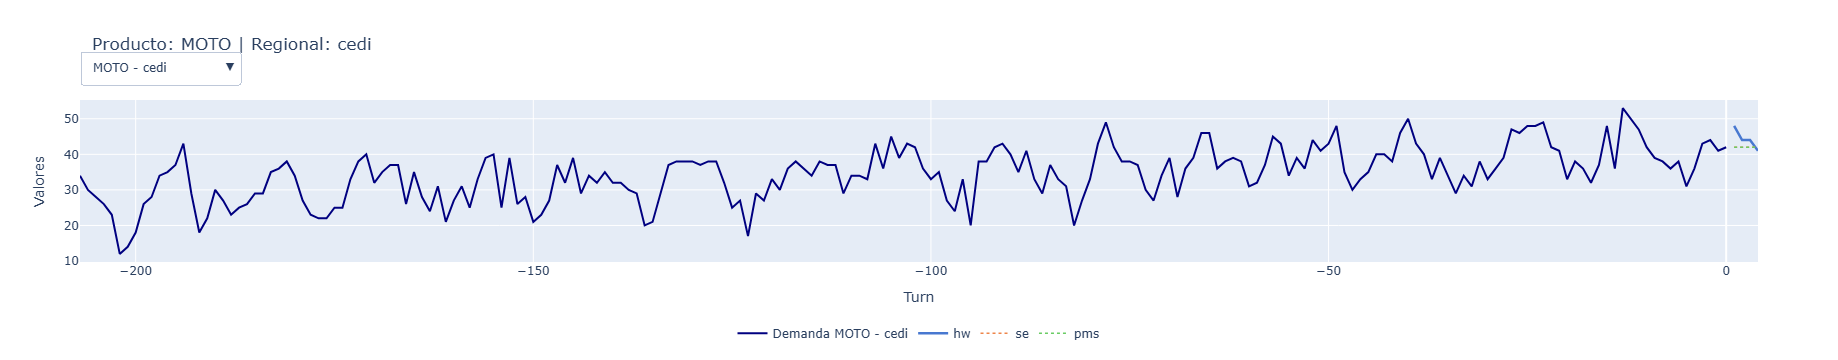

In [19]:
lags = 4
ciclos_por_año = 4
productos = df_cedi['PRODUCTO'].unique()
regionales = df_cedi['REGIONAL'].unique()

# Holt Winters
df_forecast_hw = fp.aplicar_hw(df_cedi, productos, regionales, lags, ciclos_por_año, pronostico_final=0)
print('\033[1mErrores Modelo Holt Winters:\033[0m')
grupo_sku_error_formato_hw, rmse_sku_lag_hw, rmse_sku_mes_hw = fp.kpi_error_sku(df_forecast_hw)
grupo_mes_error_formato_hw, df_test_hw = fp.kpi_error_lag(df_forecast_hw)
df_forecast_final_hw = fp.aplicar_hw(df_cedi, productos, regionales, lags, ciclos_por_año, pronostico_final=1)
df_forecast_final_hw = fp.adicionar_nombre_modelo_serie_tiempo(df_forecast_final_hw, 'hw')
df_mejor_hw = fp.agrupar_por_producto(df_forecast_hw)

# Suavizacion Exponencial
df_forecast_se = fp.aplicar_se(df_cedi, productos, regionales, lags, pronostico_final=0)
print('\033[1mErrores Modelo Suavización Exponencial:\033[0m')
grupo_sku_error_formato_se, rmse_sku_lag_se, rmse_sku_mes_se = fp.kpi_error_sku(df_forecast_se)
grupo_mes_error_formato_se, df_test_se = fp.kpi_error_lag(df_forecast_se)
df_forecast_final_se = fp.aplicar_se(df_cedi, productos, regionales, lags, pronostico_final=1)
df_forecast_final_se = fp.adicionar_nombre_modelo_serie_tiempo(df_forecast_final_se, 'se')
df_mejor_se = fp.agrupar_por_producto(df_forecast_se)

# PMS
print('\033[1mErrores Modelo Promedio Móvil Simple:\033[0m')
df_forecast_pms = fp.aplicar_pms(df_cedi, productos, regionales, lags, pronostico_final=0)
grupo_sku_error_formato_pms, rmse_sku_lag_pms, rmse_sku_mes_pms = fp.kpi_error_sku(df_forecast_pms)
grupo_mes_error_formato_pms, df_test_pms = fp.kpi_error_lag(df_forecast_pms)
df_forecast_final_pms = fp.aplicar_pms(df_cedi, productos, regionales, lags, pronostico_final=1)
df_forecast_final_pms = fp.adicionar_nombre_modelo_serie_tiempo(df_forecast_final_pms, 'pms')
df_mejor_pms = fp.agrupar_por_producto(df_forecast_pms)

# Comparacion modelos
modelos = ['hw','se','pms']
reporte_error_skus_cedi = generar_reporte_error_skus(modelos) # se ejecuta desde el mismo cuaderno
df_todos_rmse_cedi = concatenar_rmse(modelos)# se ejecuta desde el mismo cuaderno
df_minimos_cedi, df_reporte_final_cedi, reporte_error_skus_cedi, fig1_cedi, df_errores_totales_cedi = fp.comparar_y_graficar_modelos(reporte_error_skus_cedi)
fig1_cedi.show()
df_todos_pronosticos_cedi = concatenar_forecasts_pronosticos(modelos)# se ejecuta desde el mismo cuaderno

# Crear tabla final con pronosticos 
df_pronosticos_mejor_modelo_cedi, df_pronosticos_n_periodos_cedi = fp.obtener_mejor_pronostico(df_minimos_cedi, df_todos_pronosticos_cedi, df_errores_totales_cedi, df_todos_rmse_cedi)

# Creacion de tabla de errores RMSE
mejores_modelos_cedi = df_pronosticos_mejor_modelo_cedi[['PRODUCTO','REGIONAL', 'MODELO']].drop_duplicates()
rmse_ss_cedi = df_todos_rmse_cedi.merge(
    mejores_modelos_cedi,
    on=["PRODUCTO", "REGIONAL", "MODELO"],
    how="inner"  # Solo conservar las coincidencias
)

# Grafica final demanda vs mejor pronostico
fig_cedi = fp.crear_grafica_pronostico(df_cedi, df_todos_pronosticos_cedi, df_pronosticos_mejor_modelo_cedi)
fig_cedi.show()

# Generacion de pronosticos para la materia prima explosionada a nivel mototrak

## Explosion de Materiales 

In [18]:
# Ruta archivo BOM
ruta_bom = r"dataset\BOM_Mototrak.xlsx"

In [19]:
def cargar_y_preprocesar_bom(ruta):
    df_bom = pd.read_excel(ruta_bom)
    df_bom = df_bom.set_index('Product name').T.reset_index()
    df_bom = df_bom.rename(columns={'Product name': 'index', 'index': 'MATERIA_PRIMA'})
    df_bom['MATERIA_PRIMA'] = df_bom['MATERIA_PRIMA'].str.rstrip()
    df_bom_vertical = df_bom.melt(id_vars=['MATERIA_PRIMA'], 
                                var_name='PRODUCTO', 
                                value_name='CANTIDAD')
    
    df_bom_vertical = df_bom_vertical[df_bom_vertical['CANTIDAD'] != 0]
    
    # Unir los DataFrames en la columna 'PRODUCTO'
    df_explosion = df_bom_vertical.merge(df_agregado, on='PRODUCTO')
    
    # Calcular la explosion
    df_explosion['DEMANDA_MP'] = df_explosion['CANTIDAD'] * df_explosion['DEMANDA']
    
    # Ordenar columnas para mejor lectura
    df_explosion = df_explosion[['MATERIA_PRIMA', 'PRODUCTO', 'Turn', 'DEMANDA', 'CANTIDAD','DEMANDA_MP','REGIONAL']]
    
    # Agrupar demanda de mp explosinada
    df_explosion_mp = df_explosion.groupby(['MATERIA_PRIMA', 'Turn', 'REGIONAL'])['DEMANDA_MP'].sum().reset_index()
    
    # Cambiar nombre de columnas para aplicar funciones de pronosticos
    df_explosion_mp = df_explosion_mp.rename(columns={'DEMANDA_MP':'DEMANDA','MATERIA_PRIMA':'PRODUCTO'})

    return df_bom_vertical, df_explosion_mp


In [20]:
df_bom_vertical, df_explosion_mp = cargar_y_preprocesar_bom(ruta_bom)

## Calculo de pronósticos

Errores Modelo Holt Winters:
Periodo de Evaluacion desde:
-34 hasta 0
MAE% modelo: 6.84%
Sesgo% modelo: 1.59%
Score modelo: 8.44%
RMSE modelo: 56.6


,PRODUCTO,REGIONAL,MAE%,SESGO%,SCORE%
18,PIN TRIPLE AZUL,mototrak,6.52%,0.18%,6.71%
24,VIGA TRIPLE GRIS,mototrak,6.73%,0.08%,6.81%
22,VIGA DOBLE GRIS,mototrak,6.73%,0.08%,6.81%
19,PIÑON GRANDE AMARILLO,mototrak,6.73%,0.08%,6.81%
10,EJE HEXAGONAL 6.5 CM,mototrak,6.73%,0.08%,6.81%
13,LADRILLO TRIANGULAR AZUL,mototrak,5.86%,1.11%,6.97%
16,PIN DOBLE AZUL,mototrak,6.36%,0.99%,7.35%
23,VIGA SIMPLE GRIS,mototrak,6.02%,1.40%,7.43%
21,TOPE DE EJE AMARILLO,mototrak,6.13%,1.54%,7.67%
0,BLOQUE DE EJES NEGRO,mototrak,6.37%,1.53%,7.90%


Periodo de Evaluacion desde:
-34 hasta 0
MAE% modelo: 6.84%
Sesgo% modelo: 1.59%
Score modelo: 8.44%
RMSE modelo: 56.6


,LAG,MAE%,SESGO%,SCORE%
0,1,6.68%,0.88%,7.57%
1,2,6.78%,1.05%,7.83%
2,3,6.80%,1.01%,7.82%
3,4,6.76%,0.99%,7.76%
4,5,6.67%,0.76%,7.43%
5,6,6.59%,0.67%,7.26%
6,7,6.56%,1.14%,7.70%
7,8,6.62%,1.41%,8.03%
8,9,6.74%,1.50%,8.24%
9,10,6.96%,1.77%,8.73%


Errores Modelo Suavización Exponencial:
Periodo de Evaluacion desde:
-34 hasta 0
MAE% modelo: 11.68%
Sesgo% modelo: 3.96%
Score modelo: 15.64%
RMSE modelo: 91.3


,PRODUCTO,REGIONAL,MAE%,SESGO%,SCORE%
5,CUARTO LADRILLO AZUL,mototrak,9.43%,4.46%,13.88%
6,DINTEL DOBLE AMARILLO,mototrak,9.98%,4.17%,14.15%
0,BLOQUE DE EJES NEGRO,mototrak,10.33%,3.86%,14.18%
7,DINTEL SIMPLE AMARILLO,mototrak,9.61%,4.58%,14.20%
11,ESLABON DE ORUGA NEGRO,mototrak,10.38%,3.88%,14.26%
13,LADRILLO TRIANGULAR AZUL,mototrak,10.79%,3.85%,14.64%
15,MEDIO LADRILLO AZUL,mototrak,10.81%,3.87%,14.68%
12,LADRILLO COMPLETO AZUL,mototrak,10.81%,3.87%,14.68%
21,TOPE DE EJE AMARILLO,mototrak,10.82%,3.88%,14.69%
18,PIN TRIPLE AZUL,mototrak,11.46%,3.79%,15.25%


Periodo de Evaluacion desde:
-34 hasta 0
MAE% modelo: 11.68%
Sesgo% modelo: 3.96%
Score modelo: 15.64%
RMSE modelo: 91.3


,LAG,MAE%,SESGO%,SCORE%
0,1,8.52%,1.27%,9.78%
1,2,10.39%,2.02%,12.42%
2,3,11.59%,2.54%,14.13%
3,4,12.71%,3.12%,15.83%
4,5,13.44%,2.99%,16.42%
5,6,13.89%,2.70%,16.59%
6,7,13.60%,3.04%,16.65%
7,8,12.77%,3.18%,15.95%
8,9,11.86%,3.09%,14.95%
9,10,10.74%,3.03%,13.77%


Errores Modelo Promedio Móvil Simple:
Periodo de Evaluacion desde:
-34 hasta 0
MAE% modelo: 11.48%
Sesgo% modelo: 4.02%
Score modelo: 15.50%
RMSE modelo: 89.9


,PRODUCTO,REGIONAL,MAE%,SESGO%,SCORE%
5,CUARTO LADRILLO AZUL,mototrak,10.04%,3.81%,13.85%
7,DINTEL SIMPLE AMARILLO,mototrak,10.00%,3.98%,13.97%
6,DINTEL DOBLE AMARILLO,mototrak,10.18%,3.82%,13.99%
0,BLOQUE DE EJES NEGRO,mototrak,10.26%,3.88%,14.14%
11,ESLABON DE ORUGA NEGRO,mototrak,10.33%,3.93%,14.26%
13,LADRILLO TRIANGULAR AZUL,mototrak,10.58%,3.91%,14.49%
12,LADRILLO COMPLETO AZUL,mototrak,10.60%,3.94%,14.53%
15,MEDIO LADRILLO AZUL,mototrak,10.60%,3.95%,14.55%
21,TOPE DE EJE AMARILLO,mototrak,10.61%,3.96%,14.58%
18,PIN TRIPLE AZUL,mototrak,11.36%,3.81%,15.18%


Periodo de Evaluacion desde:
-34 hasta 0
MAE% modelo: 11.48%
Sesgo% modelo: 4.02%
Score modelo: 15.50%
RMSE modelo: 89.9


,LAG,MAE%,SESGO%,SCORE%
0,1,9.36%,1.40%,10.77%
1,2,10.84%,2.17%,13.00%
2,3,12.24%,2.64%,14.87%
3,4,12.85%,2.96%,15.80%
4,5,13.38%,2.75%,16.14%
5,6,13.43%,2.57%,16.00%
6,7,12.67%,2.96%,15.63%
7,8,12.17%,3.17%,15.34%
8,9,10.86%,3.03%,13.89%
9,10,9.42%,3.10%,12.51%


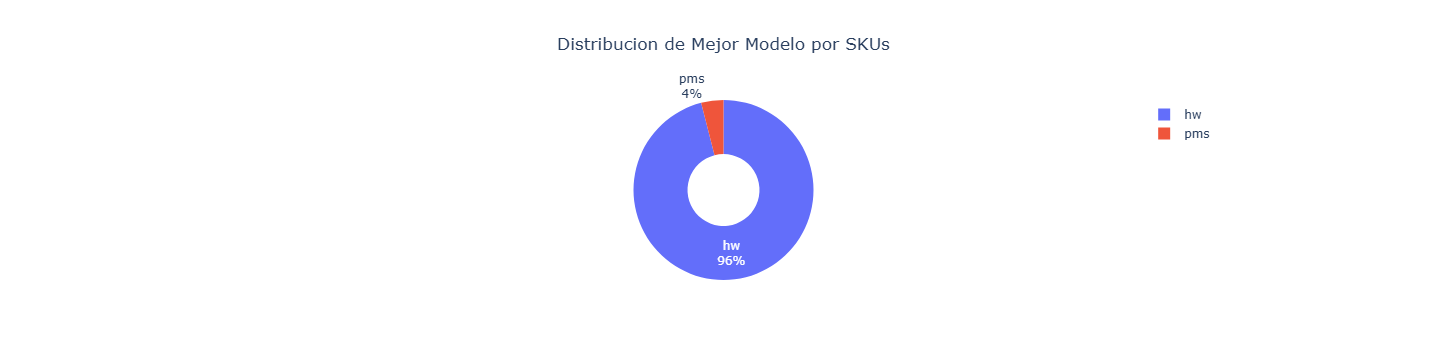

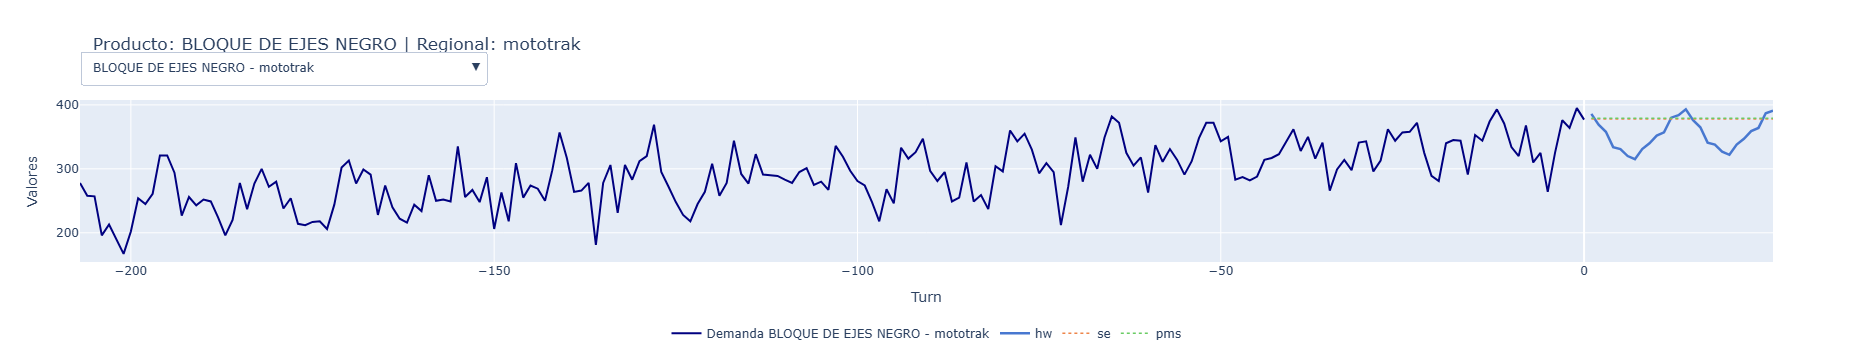

In [21]:
lags = 26
ciclos_por_año = 4
materias_primas = df_explosion_mp['PRODUCTO'].unique()
regionales = df_explosion_mp['REGIONAL'].unique()

# Holt Winters
df_forecast_hw = fp.aplicar_hw(df_explosion_mp, materias_primas, regionales, lags, ciclos_por_año, pronostico_final=0)
print('\033[1mErrores Modelo Holt Winters:\033[0m')
grupo_sku_error_formato_hw, rmse_sku_lag_hw, rmse_sku_mes_hw = fp.kpi_error_sku(df_forecast_hw)
grupo_mes_error_formato_hw, df_test_hw = fp.kpi_error_lag(df_forecast_hw)
df_forecast_final_hw = fp.aplicar_hw(df_explosion_mp, materias_primas, regionales, lags, ciclos_por_año, pronostico_final=1)
df_forecast_final_hw = fp.adicionar_nombre_modelo_serie_tiempo(df_forecast_final_hw, 'hw')
df_mejor_hw = fp.agrupar_por_producto(df_forecast_hw)

# Suavizacion Exponencial
df_forecast_se = fp.aplicar_se(df_explosion_mp, materias_primas, regionales, lags, pronostico_final=0)
print('\033[1mErrores Modelo Suavización Exponencial:\033[0m')
grupo_sku_error_formato_se, rmse_sku_lag_se, rmse_sku_mes_se = fp.kpi_error_sku(df_forecast_se)
grupo_mes_error_formato_se, df_test_se = fp.kpi_error_lag(df_forecast_se)
df_forecast_final_se = fp.aplicar_se(df_explosion_mp, materias_primas, regionales, lags, pronostico_final=1)
df_forecast_final_se = fp.adicionar_nombre_modelo_serie_tiempo(df_forecast_final_se, 'se')
df_mejor_se = fp.agrupar_por_producto(df_forecast_se)

# PMS
print('\033[1mErrores Modelo Promedio Móvil Simple:\033[0m')
df_forecast_pms = fp.aplicar_pms(df_explosion_mp, materias_primas, regionales, lags, pronostico_final=0)
grupo_sku_error_formato_pms, rmse_sku_lag_pms, rmse_sku_mes_pms = fp.kpi_error_sku(df_forecast_pms)
grupo_mes_error_formato_pms, df_test_pms = fp.kpi_error_lag(df_forecast_pms)
df_forecast_final_pms = fp.aplicar_pms(df_explosion_mp, materias_primas, regionales, lags, pronostico_final=1)
df_forecast_final_pms = fp.adicionar_nombre_modelo_serie_tiempo(df_forecast_final_pms, 'pms')
df_mejor_pms = fp.agrupar_por_producto(df_forecast_pms)

# Comparacion modelos
modelos_mp = ['hw','se','pms']
reporte_error_skus_mp = generar_reporte_error_skus(modelos_mp) # se ejecuta desde el mismo cuaderno
df_todos_rmse_mp = concatenar_rmse(modelos_mp)# se ejecuta desde el mismo cuaderno
df_minimos_mp, df_reporte_final_mp, reporte_error_skus_mp, fig1_mp, df_errores_totales_mp = fp.comparar_y_graficar_modelos(reporte_error_skus_mp)
fig1_mp.show()
df_todos_pronosticos_mp = concatenar_forecasts_pronosticos(modelos_mp)# se ejecuta desde el mismo cuaderno

# Crear tabla final con pronosticos 
df_pronosticos_mejor_modelo_mp, df_pronosticos_n_periodos_mp = fp.obtener_mejor_pronostico(df_minimos_mp, df_todos_pronosticos_mp, df_errores_totales_mp, df_todos_rmse_mp)

mejores_modelos_mp = df_pronosticos_mejor_modelo_mp[['PRODUCTO','REGIONAL', 'MODELO']].drop_duplicates()
# Creacion de tabla de errores RMSE mp
rmse_ss_mp = df_todos_rmse_mp.merge(
    mejores_modelos_mp,
    on=["PRODUCTO", "REGIONAL", "MODELO"],
    how="inner"  # Solo conservar las coincidencias
)
# Grafica final demanda vs mejor pronostico
fig_mp = fp.crear_grafica_pronostico(df_explosion_mp, df_todos_pronosticos_mp, df_pronosticos_mejor_modelo_mp)
fig_mp.show()

# Generacion de pronosticos para la carga de minutos de cada centro de trabajo

## Explosion de Carga en Minutos

In [23]:
# Ruta archivo de tiempos de carga
ruta_tiempos = r"dataset\INFO_MAESTRA_BOM_TIEMPOS.xlsx"

In [47]:
# Cargar datos
df_tiempos = pd.read_excel(ruta_tiempos, sheet_name = 'M_D_O')
# Preprocesar tabla
df_tiempos = df_tiempos.reset_index().drop(columns='index').rename(
                                columns={'PRODUCTO': 'PROCESO'}).iloc[:,:-2]
df_tiempos

,PROCESO,MOTO,CUATRIMOTO,TRACTOR
0,ARMAR BASE,20,20,20
1,ARMAR CHASIS,180,89,245
2,RUEDAS - ORUGA,295,235,150
3,ASIENTO - VOLANTE,50,150,100


In [44]:
# Convertir a Vertical
df_tiempos_vertical = df_tiempos.melt(id_vars=['PROCESO'], 
                                var_name='PRODUCTO', 
                                value_name='MINUTOS')
df_tiempos_vertical

,PROCESO,PRODUCTO,MINUTOS
0,ARMAR BASE,MOTO,20
1,ARMAR CHASIS,MOTO,180
2,RUEDAS - ORUGA,MOTO,295
3,ASIENTO - VOLANTE,MOTO,50
4,ARMAR BASE,CUATRIMOTO,20
5,ARMAR CHASIS,CUATRIMOTO,89
6,RUEDAS - ORUGA,CUATRIMOTO,235
7,ASIENTO - VOLANTE,CUATRIMOTO,150
8,ARMAR BASE,TRACTOR,20
9,ARMAR CHASIS,TRACTOR,245


In [27]:
# Cargar datos
df_tiempos = pd.read_excel(ruta_tiempos, sheet_name = 'M_D_O')

# Preprocesar tabla
df_tiempos = df_tiempos.set_index('PRODUCTO').T.reset_index().rename(
                                columns={'index': 'PROCESO'})

# Convertir a Vertical
df_tiempos_vertical = df_tiempos.melt(id_vars=['PROCESO'], 
                                var_name='PRODUCTO', 
                                value_name='MINUTOS')

# Eliimnar lineas con 0 minutos
df_tiempos_vertical  = df_tiempos_vertical[df_tiempos_vertical['MINUTOS'] != 0]

# Fusionar con demanda agregada
df_carga = df_tiempos_vertical.merge(df_agregado, on='PRODUCTO')

# Calcular la explosion
df_carga['DEMANDA_MIN'] = df_carga['MINUTOS'] * df_carga['DEMANDA']

# Ordenar columnas para mejor lectura
df_carga = df_carga[['PROCESO', 'PRODUCTO', 'Turn', 'DEMANDA', 'MINUTOS', 'DEMANDA_MIN', 'REGIONAL']]

# Agrupar demanda de mp explosinada
df_explosion_min = df_carga.groupby(['PROCESO', 'Turn', 'REGIONAL'])['DEMANDA_MIN'].sum().reset_index()

# Cambiar nombre de columnas para aplicar funciones de pronosticos
df_explosion_min = df_explosion_min.rename(columns={'DEMANDA_MIN':'DEMANDA','PROCESO':'PRODUCTO'})

df_explosion_min

,PRODUCTO,Turn,REGIONAL,DEMANDA


In [25]:
df_tiempos

,PRODUCTO,MOTO,CUATRIMOTO,TRACTOR,COSTO,LEAD_TIME PRODUCCION_SEM,LEAD_TIME_TRANSPORTE_SEM,DIMENSIONES M3
0,CUARTO LADRILLO AZUL,1,2,2,10000,1,1,0.019360
1,MEDIO LADRILLO AZUL,6,6,6,20000,1,1,0.003872
2,LADRILLO COMPLETO AZUL,8,8,8,40000,1,1,0.007744
3,LADRILLO TRIANGULAR AZUL,2,2,2,25000,2,1,0.003630
4,DINTEL SIMPLE AMARILLO,1,3,3,20000,1,1,0.007744
5,DINTEL DOBLE AMARILLO,2,4,3,40000,1,1,0.015488
6,DINTEL TRIPLE AMARILLO,0,0,3,100000,1,1,0.023232
7,BLOQUE REDONDO SENCILLO AMARILLO,7,0,3,50000,1,1,0.003872
8,MEDIO BLOQUE REDONDEO AMARILLO,0,2,2,40000,1,1,0.001936
9,BLOQUE REDONDO MACHO-MACHO AMARILLO,8,0,2,50000,1,1,0.003872


## Calculo de pronosticos para los tiempos de carga

lags = 26
ciclos_por_año = 4
procesos = df_explosion_min['PRODUCTO'].unique()
regionales = df_explosion_min['REGIONAL'].unique()

# Holt Winters
df_forecast_hw = fp.aplicar_hw(df_explosion_min, procesos, regionales, lags, ciclos_por_año, pronostico_final=0)
print('\033[1mErrores Modelo Holt Winters:\033[0m')
grupo_sku_error_formato_hw, rmse_sku_lag_hw, rmse_sku_mes_hw = fp.kpi_error_sku(df_forecast_hw)
grupo_mes_error_formato_hw, df_test_hw = fp.kpi_error_lag(df_forecast_hw)
df_forecast_final_hw = fp.aplicar_hw(df_explosion_min, procesos, regionales, lags, ciclos_por_año, pronostico_final=1)
df_forecast_final_hw = fp.adicionar_nombre_modelo_serie_tiempo(df_forecast_final_hw, 'hw')
df_mejor_hw = fp.agrupar_por_producto(df_forecast_hw)

# Suavizacion Exponencial
df_forecast_se = fp.aplicar_se(df_explosion_min, procesos, regionales, lags, pronostico_final=0)
print('\033[1mErrores Modelo Suavización Exponencial:\033[0m')
grupo_sku_error_formato_se, rmse_sku_lag_se, rmse_sku_mes_se = fp.kpi_error_sku(df_forecast_se)
grupo_mes_error_formato_se, df_test_se = fp.kpi_error_lag(df_forecast_se)
df_forecast_final_se = fp.aplicar_se(df_explosion_min, procesos, regionales, lags, pronostico_final=1)
df_forecast_final_se = fp.adicionar_nombre_modelo_serie_tiempo(df_forecast_final_se, 'se')
df_mejor_se = fp.agrupar_por_producto(df_forecast_se)

# PMS
print('\033[1mErrores Modelo Promedio Móvil Simple:\033[0m')
df_forecast_pms = fp.aplicar_pms(df_explosion_min, procesos, regionales, lags, pronostico_final=0)
grupo_sku_error_formato_pms, rmse_sku_lag_pms, rmse_sku_mes_pms = fp.kpi_error_sku(df_forecast_pms)
grupo_mes_error_formato_pms, df_test_pms = fp.kpi_error_lag(df_forecast_pms)
df_forecast_final_pms = fp.aplicar_pms(df_explosion_min, procesos, regionales, lags, pronostico_final=1)
df_forecast_final_pms = fp.adicionar_nombre_modelo_serie_tiempo(df_forecast_final_pms, 'pms')
df_mejor_pms = fp.agrupar_por_producto(df_forecast_pms)

# Comparacion modelos
modelos_min = ['hw','se','pms']
reporte_error_skus_min = generar_reporte_error_skus(modelos_min) # se ejecuta desde el mismo cuaderno
df_todos_rmse_min = concatenar_rmse(modelos_min)# se ejecuta desde el mismo cuaderno
df_minimos_min, df_reporte_final_min, reporte_error_skus_min, fig1_min, df_errores_totales_min = fp.comparar_y_graficar_modelos(reporte_error_skus_min)
fig1_min.show()
df_todos_pronosticos_min = concatenar_forecasts_pronosticos(modelos_min)# se ejecuta desde el mismo cuaderno

# Crear tabla final con pronosticos 
df_pronosticos_mejor_modelo_min, df_pronosticos_n_periodos_min = fp.obtener_mejor_pronostico(df_minimos_min, df_todos_pronosticos_min, df_errores_totales_min, df_todos_rmse_min)

mejores_modelos_mp = df_pronosticos_mejor_modelo_mp[['PRODUCTO','REGIONAL', 'MODELO']].drop_duplicates()
rmse_ss_mp = df_todos_rmse_mp.merge(
    mejores_modelos_mp,
    on=["PRODUCTO", "REGIONAL", "MODELO"],
    how="inner"  # Solo conservar las coincidencias
)

# Grafica final demanda vs mejor pronostico
fig_min = fp.crear_grafica_pronostico(df_explosion_min, df_todos_pronosticos_min, df_pronosticos_mejor_modelo_min)
fig_min.show()

# Modelos de Inventarios

## Lead times producto terminado en los diferentes eslabones

In [24]:
# Tabla de leadtimes de distribucion de producto terminado
lt_pt = pd.DataFrame({"REGIONAL": ["norte", "centro", "sur", "cedi"],
                       "LEAD_TIME_DIST":[1,1,1,1],
                       "REVIEW_PERIOD":[1,1,1,1],
                      "LEAD_TIME_PROD":0,
                     # "PRODUCTO": [productos]*4
                      })
lt_pt

,REGIONAL,LEAD_TIME_DIST,REVIEW_PERIOD,LEAD_TIME_PROD
0,norte,1,1,0
1,centro,1,1,0
2,sur,1,1,0
3,cedi,1,1,0


In [25]:
# Repetir cada fila por la cantidad de productos y asignar la nueva columna
lt_pt = lt_pt.loc[lt_pt.index.repeat(len(productos))].reset_index(drop=True)
lt_pt["PRODUCTO"] = np.tile(productos, len(lt_pt) // len(productos))
lt_pt

,REGIONAL,LEAD_TIME_DIST,REVIEW_PERIOD,LEAD_TIME_PROD,PRODUCTO
0,norte,1,1,0,MOTO
1,norte,1,1,0,CUATRIMOTO
2,norte,1,1,0,TRACTOR
3,centro,1,1,0,MOTO
4,centro,1,1,0,CUATRIMOTO
5,centro,1,1,0,TRACTOR
6,sur,1,1,0,MOTO
7,sur,1,1,0,CUATRIMOTO
8,sur,1,1,0,TRACTOR
9,cedi,1,1,0,MOTO


## Lead times materia prima

In [26]:
lt_mp_pccn_dict = [2,1,1,1,2,1,1,1,1,2,2,2,1,2,1,1,1,1,1,2,2,1,2,2,2]
lt_mp_dist_dict = [4,1,1,1,4,1,1,1,1,4,4,4,1,1,1,1,1,1,1,1,1,1,4,4,4]
review_period = [1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1]
lt_mp = pd.DataFrame({'PRODUCTO':materias_primas,'LEAD_TIME_PROD':lt_mp_pccn_dict, 'LEAD_TIME_DIST':lt_mp_dist_dict, 'REVIEW_PERIOD':review_period,'REGIONAL':'mototrak'})
lt_mp

,PRODUCTO,LEAD_TIME_PROD,LEAD_TIME_DIST,REVIEW_PERIOD,REGIONAL
0,BLOQUE DE EJES NEGRO,2,4,1,mototrak
1,BLOQUE REDONDO HEMBRA-HEMBRA AMARILLO,1,1,1,mototrak
2,BLOQUE REDONDO MACHO-MACHO AMARILLO,1,1,1,mototrak
3,BLOQUE REDONDO SENCILLO AMARILLO,1,1,1,mototrak
4,COLUMNA NEGRA,2,4,1,mototrak
5,CUARTO LADRILLO AZUL,1,1,1,mototrak
6,DINTEL DOBLE AMARILLO,1,1,1,mototrak
7,DINTEL SIMPLE AMARILLO,1,1,1,mototrak
8,DINTEL TRIPLE AMARILLO,1,1,1,mototrak
9,EJE HEXAGONAL 10 CM,2,4,1,mototrak


## Stocks de producto terminado en los diferentes eslabones de la cadena

In [27]:
# Stock actual de producto terminado
stock_norte = pd.DataFrame({
    "PRODUCTO": ["MOTO", "CUATRIMOTO", "TRACTOR"],
    "STOCK": [25, 16, 11]
})
stock_centro = pd.DataFrame({
    "PRODUCTO": ["MOTO", "CUATRIMOTO", "TRACTOR"],
    "STOCK": [51, 16, 32]
})
stock_sur = pd.DataFrame({
    "PRODUCTO": ["MOTO", "CUATRIMOTO"],
    "STOCK": [25, 10]
})
stock_cedi = pd.DataFrame({
    "PRODUCTO": ["MOTO", "CUATRIMOTO", "TRACTOR"],
    "STOCK": [109, 78, 70]
})    
stock_mototrak = pd.DataFrame({
    "PRODUCTO": ["MOTO", "CUATRIMOTO", "TRACTOR"],
    "STOCK": [126, 67, 44]
})

## Stock en mototrak (Materias Primas y PT)

In [28]:
ruta_stock_mp = r'dataset\stock_mp.csv'
df_stock_mp = pd.read_csv(ruta_stock_mp)
df_stock_mp = df_stock_mp.rename(columns={'category':'PRODUCTO','Internal storage':'STOCK'}).drop(columns='External storage')

stock_mototrak = pd.concat([stock_mototrak, df_stock_mp], ignore_index=True)
stock_mototrak

,PRODUCTO,STOCK
0,MOTO,126
1,CUATRIMOTO,67
2,TRACTOR,44
3,CUARTO LADRILLO AZUL,512
4,MEDIO LADRILLO AZUL,1883
5,LADRILLO COMPLETO AZUL,3425
6,LADRILLO TRIANGULAR AZUL,1182
7,DINTEL SIMPLE AMARILLO,1058
8,DINTEL DOBLE AMARILLO,1057
9,BLOQUE REDONDO SENCILLO AMARILLO,1097


## Clase para generar politicas

In [29]:
df_pronosticos = pd.concat([df_pronosticos_mejor_modelo, df_pronosticos_mejor_modelo_mp, df_pronosticos_mejor_modelo_cedi], ignore_index=True)
rmse_ss = pd.concat([rmse_ss, rmse_ss_cedi, rmse_ss_mp], ignore_index=True)
lt = pd.concat([lt_pt, lt_mp], ignore_index=True)

In [30]:
class InventoryModel:
    def __init__(self, stock_norte, 
                 stock_centro, stock_sur, 
                 stock_cedi, 
                 stock_mototrak,  
                 pronosticos, 
                 rmse_ss,
                 lt):
        
        # Crear un diccionario para almacenar los stocks por regional
        self.stock = {
            "norte": stock_norte,
            "centro": stock_centro,
            "sur": stock_sur,
            "cedi": stock_cedi,
            "mototrak": stock_mototrak
        }
        self.pronosticos = pronosticos
        self.rmse_ss = rmse_ss
        self.lt = lt 

    
    def get_stock_maximo(self, producto, regional, k):
        """
        Calcula el stock máximo para un producto en una regional específica.
        Si no existe la combinación, devuelve None.
        """
        # Verificar que el regional exista en el diccionario de stocks
        if regional not in self.stock:
            return None
        
        # Filtrar pronósticos para el producto y regional
        pronosticos_filtro = self.pronosticos[
            (self.pronosticos["PRODUCTO"] == producto) &
            (self.pronosticos["REGIONAL"] == regional)
        ]
        
        # Verificar que haya pronósticos para la combinación
        if pronosticos_filtro.empty:
            return None

        # Obtener la suma de LEAD_TIME_DIST + LEAD_TIME_PROD + REVIEW_PERIOD para la regional
        lt_filtro = self.lt[
            (self.lt["PRODUCTO"] == producto) &
            (self.lt["REGIONAL"] == regional)
        ]

        # Calcular periodo de riesgo y generar lista de periodos a sumar
        periodo_riesgo = (lt_filtro["LEAD_TIME_DIST"] + lt_filtro["LEAD_TIME_PROD"] + lt_filtro["REVIEW_PERIOD"]).values[0] if not lt_filtro.empty else 2 
        turno_inicial = pronosticos_filtro['Turn'].min()
        lista_periodos = list(range(turno_inicial, periodo_riesgo + turno_inicial))
               
        # Sumar los pronósticos de los dos períodos siguientes
        forecast_suma = pronosticos_filtro.loc[pronosticos_filtro["Turn"].isin(lista_periodos), "FORECAST"].sum()
               
        # Obtener el RMSE correspondiente
        rmse_filtro = self.rmse_ss[
            (self.rmse_ss["PRODUCTO"] == producto) &
            (self.rmse_ss["REGIONAL"] == regional)
        ]
        rmse = rmse_filtro["RMSE"].values[0] if not rmse_filtro.empty else 0       

        # Calcular el stock máximo
        stock_max = np.ceil(forecast_suma + k * rmse * sqrt(periodo_riesgo))
        
        return stock_max

    def get_cantidad_sugerida(self, producto, regional):
        """
        Calcula la cantidad sugerida para el producto y regional.
        Si no existe la combinación, devuelve None.
        """
        # Obtener el stock máximo
        stock_max = self.get_stock_maximo(producto, regional, k)
        
        # Verificar que se haya calculado un stock máximo válido
        if stock_max is None:
            return None
        
        # Obtener el stock actual
        stock_actual_filtro = self.stock[regional]
        stock_actual = stock_actual_filtro.loc[stock_actual_filtro["PRODUCTO"] == producto, "STOCK"]
        
        # Verificar que haya un stock actual para el producto
        if stock_actual.empty:
            return None
        
        # Calcular la cantidad sugerida
        stock_actual_value = stock_actual.values[0]
        cantidad_sugerida = max(0, stock_max - stock_actual_value)
        
        return cantidad_sugerida

    def get_stock_actual(self, producto, regional):
        
        # Verificar si la regional existe en el diccionario
        if regional not in self.stock:
            return None
    
        # Obtener el DataFrame de stock correspondiente a la regional
        stock_actual_filtro = self.stock[regional]
    
        # Filtrar por producto
        stock_actual = stock_actual_filtro.loc[stock_actual_filtro["PRODUCTO"] == producto, "STOCK"]
    
        # Verificar si hay stock disponible
        if stock_actual.empty:
            return None

        return stock_actual.values[0]  # Devolver el valor en lugar de una Serie

In [31]:
# Generar listado unificado de productos y regionales
productos = df_pronosticos['PRODUCTO'].unique()
regionales = df_pronosticos['REGIONAL'].unique()

In [32]:
# Instanciar el modelo para producto terminado
modelo = InventoryModel(stock_norte, stock_centro, 
                        stock_sur, stock_cedi, 
                        stock_mototrak, df_pronosticos, 
                        rmse_ss, lt)

In [33]:
# Lista para almacenar los resultados
resultados = []
k = norm.ppf(0.95)
# Iterar sobre productos y regionales
for producto in productos:
    for regional in regionales:
        # Calcular stock máximo y cantidad sugerida
        stock_max = modelo.get_stock_maximo(producto, regional, 
                                            #turnos, 
                                            k)
        cantidad_sugerida = modelo.get_cantidad_sugerida(producto, regional)
        stock_actual = modelo.get_stock_actual(producto, regional)
        
        # Agregar los resultados a la lista
        resultados.append({
            "REGIONAL": regional,
            "PRODUCTO": producto,            
            "STOCK_MAXIMO": stock_max,
            "STOCK_ACTUAL": stock_actual,
            "CANTIDAD_SUGERIDA": cantidad_sugerida
        })

# Convertir la lista en un DataFrame
df_resultados = pd.DataFrame(resultados).dropna().sort_values(by="REGIONAL", ascending=True)

# Suponiendo que df_resultados ya está definido
df_resultados_finales = df_resultados.copy()

# Crear un diccionario con la cantidad sugerida de los productos en cedi
cedi_dict = df_resultados[df_resultados["REGIONAL"] == "cedi"].set_index("PRODUCTO")["CANTIDAD_SUGERIDA"].to_dict()

# Actualizar la CANTIDAD_SUGERIDA en mototrak sumando el valor de cedi si existe
df_resultados_finales.loc[df_resultados_finales["REGIONAL"] == "mototrak", "CANTIDAD_SUGERIDA"] += df_resultados_finales["PRODUCTO"].map(cedi_dict).fillna(0)

# Verificar el resultado
df_resultados_finales

,REGIONAL,PRODUCTO,STOCK_MAXIMO,STOCK_ACTUAL,CANTIDAD_SUGERIDA
4,cedi,MOTO,102.0,109.0,0.0
9,cedi,CUATRIMOTO,49.0,78.0,0.0
14,cedi,TRACTOR,30.0,70.0,0.0
11,centro,TRACTOR,30.0,32.0,0.0
1,centro,MOTO,62.0,51.0,11.0
6,centro,CUATRIMOTO,29.0,16.0,13.0
67,mototrak,VIGA SIMPLE GRIS,4735.0,4500.0,235.0
72,mototrak,EJE HEXAGONAL 10 CM,658.0,856.0,0.0
77,mototrak,MEDIO BLOQUE REDONDEO AMARILLO,305.0,597.0,0.0
82,mototrak,PIN DOBLE AZUL,1608.0,1983.0,0.0


In [34]:
df_resultados_finales[df_resultados_finales['REGIONAL'] == 'mototrak']

,REGIONAL,PRODUCTO,STOCK_MAXIMO,STOCK_ACTUAL,CANTIDAD_SUGERIDA
67,mototrak,VIGA SIMPLE GRIS,4735.0,4500.0,235.0
72,mototrak,EJE HEXAGONAL 10 CM,658.0,856.0,0.0
77,mototrak,MEDIO BLOQUE REDONDEO AMARILLO,305.0,597.0,0.0
82,mototrak,PIN DOBLE AZUL,1608.0,1983.0,0.0
87,mototrak,PIÑON PEQUEÑO AMARILLO,790.0,1323.0,0.0
92,mototrak,COLUMNA NEGRA,622.0,988.0,0.0
42,mototrak,LADRILLO TRIANGULAR AZUL,893.0,1182.0,0.0
102,mototrak,BLOQUE REDONDO HEMBRA-HEMBRA AMARILLO,701.0,1086.0,0.0
62,mototrak,PIN TRIPLE AZUL,1007.0,1194.0,0.0
107,mototrak,BLOQUE REDONDO SENCILLO AMARILLO,1567.0,1097.0,470.0


# Costos

In [35]:
df_bom_vertical

,MATERIA_PRIMA,PRODUCTO,CANTIDAD
0,CUARTO LADRILLO AZUL,MOTO,1
1,MEDIO LADRILLO AZUL,MOTO,6
2,LADRILLO COMPLETO AZUL,MOTO,8
3,LADRILLO TRIANGULAR AZUL,MOTO,2
4,DINTEL SIMPLE AMARILLO,MOTO,1
5,DINTEL DOBLE AMARILLO,MOTO,2
7,BLOQUE REDONDO SENCILLO AMARILLO,MOTO,7
9,BLOQUE REDONDO MACHO-MACHO AMARILLO,MOTO,8
10,BLOQUE REDONDO HEMBRA-HEMBRA AMARILLO,MOTO,3
12,PIÑON GRANDE AMARILLO,MOTO,2


In [36]:
costo_mp = pd.DataFrame({'PRODUCTO':df_bom_vertical['MATERIA_PRIMA'].unique()})

In [37]:
costo_mp

,PRODUCTO
0,CUARTO LADRILLO AZUL
1,MEDIO LADRILLO AZUL
2,LADRILLO COMPLETO AZUL
3,LADRILLO TRIANGULAR AZUL
4,DINTEL SIMPLE AMARILLO
5,DINTEL DOBLE AMARILLO
6,BLOQUE REDONDO SENCILLO AMARILLO
7,BLOQUE REDONDO MACHO-MACHO AMARILLO
8,BLOQUE REDONDO HEMBRA-HEMBRA AMARILLO
9,PIÑON GRANDE AMARILLO


In [38]:
df_costos_mp = pd.read_excel(r"dataset\BOM_y_Tiempos_Mototrak.xlsx", sheet_name='BOM_MP')
df_costos_mp['CE_CO'] = 'MP'
df_costos_mp

,PRODUCTO,MOTO,CUATRIMOTO,TRACTOR,COSTO,CE_CO
0,CUARTO LADRILLO AZUL,1,2,2,10000,MP
1,MEDIO LADRILLO AZUL,6,6,6,20000,MP
2,LADRILLO COMPLETO AZUL,8,8,8,40000,MP
3,LADRILLO TRIANGULAR AZUL,2,2,2,25000,MP
4,DINTEL SIMPLE AMARILLO,1,3,3,20000,MP
5,DINTEL DOBLE AMARILLO,2,4,3,40000,MP
6,DINTEL TRIPLE AMARILLO,0,0,3,100000,MP
7,BLOQUE REDONDO SENCILLO AMARILLO,7,0,3,50000,MP
8,MEDIO BLOQUE REDONDEO AMARILLO,0,2,2,40000,MP
9,BLOQUE REDONDO MACHO-MACHO AMARILLO,8,0,2,50000,MP


In [39]:
df_costos_mod = pd.read_excel(r"dataset\BOM_y_Tiempos_Mototrak.xlsx", sheet_name='M_D_O')
df_costos_mod['CE_CO'] = 'MANO_DE_OBRA'
df_costos_mod

,PRODUCTO,MOTO,CUATRIMOTO,TRACTOR,COSTO,CE_CO
0,MOTO PASO 1: Armar Base,6,0,0,2500,MANO_DE_OBRA
1,MOTO PASO 2: Armar Chasis 1,99,0,0,2500,MANO_DE_OBRA
2,MOTO PASO 3: Armar Chasis 3,61,0,0,2500,MANO_DE_OBRA
3,MOTO PASO 4: Armar Chasis 3,9,0,0,2500,MANO_DE_OBRA
4,MOTO PASO 5: Armar Chasis 4,78,0,0,2500,MANO_DE_OBRA
5,MOTO PASO 6: Ruedas,80,0,0,2500,MANO_DE_OBRA
6,MOTO PASO 7: Ensamble Rueda Trasera,77,0,0,2500,MANO_DE_OBRA
7,MOTO PASO 8: Ensamblar Rueda Delantera,187,0,0,2500,MANO_DE_OBRA
8,MOTO PASO 9: Ensamblar Asientos,60,0,0,2500,MANO_DE_OBRA
9,CUATRIMOTO PASO 1: Armar Base,0,20,0,2000,MANO_DE_OBRA


In [40]:
df_costos = pd.concat([df_costos_mp, df_costos_mod])
# Calcular costos totales por producto y vehículo
df_costos["COSTO_MOTO"] = df_costos["MOTO"] * df_costos["COSTO"]
df_costos["COSTO_CUATRIMOTO"] = df_costos["CUATRIMOTO"] * df_costos["COSTO"]
df_costos["COSTO_TRACTOR"] = df_costos["TRACTOR"] * df_costos["COSTO"]

# Agrupar por CE_CO y sumar los costos
df_resultado = df_costos.groupby("CE_CO")[["COSTO_MOTO", "COSTO_CUATRIMOTO", "COSTO_TRACTOR"]].sum()
# Agregar fila de costo total
df_resultado.loc["COSTO_TOTAL"] = df_resultado.sum()

# Insertar precio
precio = [7000000, 9000000, 11000000]
df_resultado.loc["PRECIO"] = precio
df_resultado.index.name = None
# Mostrar el resultado
df_costos_totales = df_resultado.T
df_costos_totales['MARGEN'] = df_costos_totales['PRECIO'] - df_costos_totales['COSTO_TOTAL']
df_costos_totales['MARGEN%'] = (df_costos_totales['MARGEN']/df_costos_totales['PRECIO']).round(2)

df_costos_totales = df_costos_totales.reset_index()

df_costos_totales = df_costos_totales.rename(columns={"index":'PRODUCTO'})

df_costos_totales['PRODUCTO'] = df_costos_totales['PRODUCTO'].str.replace("COSTO_", "")

df_costos_totales

,PRODUCTO,MANO_DE_OBRA,MP,COSTO_TOTAL,PRECIO,MARGEN,MARGEN%
0,MOTO,1642500,3927000,5569500,7000000,1430500,0.20
1,CUATRIMOTO,1250000,3788000,5038000,9000000,3962000,0.44
2,TRACTOR,1674000,4140000,5814000,11000000,5186000,0.47


In [41]:
df_pronosticos_mejor_modelo

,PRODUCTO,REGIONAL,Turn,FORECAST,LAG,MODELO
52,MOTO,sur,1,21.0,1,hw
53,MOTO,sur,2,19.0,2,hw
54,MOTO,sur,3,18.0,3,hw
55,MOTO,sur,4,17.0,4,hw
56,MOTO,sur,5,16.0,5,hw
...,...,...,...,...,...,...
255,TRACTOR,norte,22,3.0,22,hw
256,TRACTOR,norte,23,4.0,23,hw
257,TRACTOR,norte,24,4.0,24,hw
258,TRACTOR,norte,25,3.0,25,hw


In [42]:
df_suma_forecast = df_pronosticos_mejor_modelo.groupby("PRODUCTO")["FORECAST"].sum().reset_index()

In [43]:
df_suma_forecast

,PRODUCTO,FORECAST
0,CUATRIMOTO,1600.0
1,MOTO,3094.0
2,TRACTOR,740.0


In [44]:
df_costos_totales = df_costos_totales.merge(df_suma_forecast, on="PRODUCTO", how="left")

In [45]:
df_costos_totales

,PRODUCTO,MANO_DE_OBRA,MP,COSTO_TOTAL,PRECIO,MARGEN,MARGEN%,FORECAST
0,MOTO,1642500,3927000,5569500,7000000,1430500,0.20,3094.0
1,CUATRIMOTO,1250000,3788000,5038000,9000000,3962000,0.44,1600.0
2,TRACTOR,1674000,4140000,5814000,11000000,5186000,0.47,740.0


In [46]:
df_costos_totales['UTILIDAD_TOTAL'] = df_costos_totales['MARGEN'] * df_costos_totales['FORECAST']
df_costos_totales

,PRODUCTO,MANO_DE_OBRA,MP,COSTO_TOTAL,PRECIO,MARGEN,MARGEN%,FORECAST,UTILIDAD_TOTAL
0,MOTO,1642500,3927000,5569500,7000000,1430500,0.20,3094.0,4.425967e+09
1,CUATRIMOTO,1250000,3788000,5038000,9000000,3962000,0.44,1600.0,6.339200e+09
2,TRACTOR,1674000,4140000,5814000,11000000,5186000,0.47,740.0,3.837640e+09


In [47]:
costo_promedio = df_costos_totales['COSTO_TOTAL'].mean()
costo_promedio

5473833.333333333

In [48]:
costo_promedio*0.25

1368458.3333333333

# EOQ

In [86]:
costos_almacenar = pd.DataFrame({'REGIONAL':['norte', 'centro', 'sur', 'cedi','mototrak'], 
                                 'COSTO_FIJO':[1750000,2000000,1500000,1000000,2500000],
                                 'COSTO_UD_ALM':[12000,10000,12000,6000,5000],
                                 'COSTO_UD_ALM_EXT':[18000,16000,16000,25000,10000], 
                                 'CAP_ALM':[890,720,580,2304,2880], 
                                 'CAP_ALM_EXT':[172,72,72,560,680]
                                })

costos_transporte_mp = pd.DataFrame({'PROVEEDOR':['azul', 'amarillo', 'gris-negro'],
                                  'COSTO_FLETE':[2000000,2000000,12000000]})

costos_transporte_pt = pd.DataFrame({'REGIONAL':['norte', 'centro', 'sur', 'cedi'], 
                                 'COSTO_FLETE':[2500000,1000000,1000000,1000000],
                                      })

display(costos_almacenar)
display(costos_transporte_mp)
display(costos_transporte_pt)

,REGIONAL,COSTO_FIJO,COSTO_UD_ALM,COSTO_UD_ALM_EXT,CAP_ALM,CAP_ALM_EXT
0,norte,1750000,12000,18000,890,172
1,centro,2000000,10000,16000,720,72
2,sur,1500000,12000,16000,580,72
3,cedi,1000000,6000,25000,2304,560
4,mototrak,2500000,5000,10000,2880,680


,PROVEEDOR,COSTO_FLETE
0,azul,2000000
1,amarillo,2000000
2,gris-negro,12000000


,REGIONAL,COSTO_FLETE
0,norte,2500000
1,centro,1000000
2,sur,1000000
3,cedi,1000000


In [87]:
# Valores unitarios de los productos
valores_unitarios = {'MOTO': 7_000_000, 'CUATRIMOTO': 6_000_000, 'TRACTOR': 12_000_000}

# Demandas promedio por regional
demandas = {
    'norte': {'MOTO': 12, 'CUATRIMOTO': 7, 'TRACTOR': 4},
    'centro': {'MOTO': 19, 'CUATRIMOTO': 10, 'TRACTOR': 9},
    'sur': {'MOTO': 15, 'CUATRIMOTO': 10, 'TRACTOR': 0},
    'cedi': {},  # Se calcula después
    'mototrak': {'MOTO': 45, 'CUATRIMOTO': 26, 'TRACTOR': 13}
}

# Calcular demanda para 'cedi' como la suma de 'centro' y 'sur'
demandas['cedi'] = {k: demandas['centro'][k] + demandas['sur'][k] for k in valores_unitarios}

# DataFrame de resultados
resultados = []

# Calcular costos de almacenamiento
for regional, data in demandas.items():
    costo_fijo_anual = costos_almacenar.loc[costos_almacenar['REGIONAL'] == regional, 'COSTO_FIJO'].values[0] * 12
    costo_ud_alm = costos_almacenar.loc[costos_almacenar['REGIONAL'] == regional, 'COSTO_UD_ALM'].values[0]
    cap_alm = costos_almacenar.loc[costos_almacenar['REGIONAL'] == regional, 'CAP_ALM'].values[0]
    
    # Costo variable basado en la ocupación de la bodega
    ocupacion_total = sum(data[p] for p in valores_unitarios)
    ocupacion = min(ocupacion_total, cap_alm)  # Lo que cabe en la bodega principal
    costo_variable = ocupacion * costo_ud_alm * 12  # Costos anuales
    
    # Si hay sobrecapacidad, usar almacenamiento externo
    costo_ext = 0
    if ocupacion_total > cap_alm:
        costo_ud_ext = costos_almacenar.loc[costos['REGIONAL'] == regional, 'COSTO_UD_ALM_EXT'].values[0]
        cap_ext = costos_almacenar.loc[costos_almacenar['REGIONAL'] == regional, 'CAP_ALM_EXT'].values[0]
        ocupacion_ext = min(ocupacion_total - cap_alm, cap_ext)
        costo_ext = ocupacion_ext * costo_ud_ext * 12
    
    costo_total = costo_fijo_anual + costo_variable + costo_ext
    
    # Calcular r para cada producto
    for producto, demanda in data.items():
        valor_inventario = demanda * valores_unitarios[producto]
        r = costo_total / valor_inventario if valor_inventario > 0 else 0
        resultados.append({'REGIONAL': regional, 'PRODUCTO': producto, 'r ($/$/año)': r})

# Convertir resultados en DataFrame
resultados_df = pd.DataFrame(resultados)
print(resultados_df)


    REGIONAL    PRODUCTO  r ($/$/año)
0      norte        MOTO     0.289429
1      norte  CUATRIMOTO     0.578857
2      norte     TRACTOR     0.506500
3     centro        MOTO     0.214737
4     centro  CUATRIMOTO     0.476000
5     centro     TRACTOR     0.264444
6        sur        MOTO     0.205714
7        sur  CUATRIMOTO     0.360000
8        sur     TRACTOR     0.000000
9       cedi        MOTO     0.069479
10      cedi  CUATRIMOTO     0.137800
11      cedi     TRACTOR     0.153111
12  mototrak        MOTO     0.111238
13  mototrak  CUATRIMOTO     0.224615
14  mototrak     TRACTOR     0.224615


In [51]:
ocupacion_total = sum(data[p] for p in valores_unitarios)

In [52]:
ocupacion_total

84

In [67]:
demandas

{'norte': {'MOTO': 12, 'CUATRIMOTO': 7, 'TRACTOR': 4},
 'centro': {'MOTO': 19, 'CUATRIMOTO': 10, 'TRACTOR': 9},
 'sur': {'MOTO': 15, 'CUATRIMOTO': 10, 'TRACTOR': 0},
 'cedi': {'MOTO': 34, 'CUATRIMOTO': 20, 'TRACTOR': 9},
 'mototrak': {'MOTO': 45, 'CUATRIMOTO': 26, 'TRACTOR': 13}}

In [68]:
df_demandas = pd.DataFrame(demandas).reset_index().rename(columns={'index':'PRODUCTO'})
df_demandas

,PRODUCTO,norte,centro,sur,cedi,mototrak
0,MOTO,12,19,15,34,45
1,CUATRIMOTO,7,10,10,20,26
2,TRACTOR,4,9,0,9,13


In [55]:
dimensiones = pd.DataFrame({'PRODUCTO':['MOTO', 'CUATRIMOTO', 'TRACTOR'],'WIDTH':[0.8,1.1,1.2],'DEPTH':[2.2,1.2,2.5],'HEIGHT':[1.4,1.2,1.3]})
dimensiones['DIMENSION'] = dimensiones['WIDTH']*dimensiones['DEPTH']*dimensiones['HEIGHT']	
dimensiones

,PRODUCTO,WIDTH,DEPTH,HEIGHT,DIMENSION
0,MOTO,0.8,2.2,1.4,2.464
1,CUATRIMOTO,1.1,1.2,1.2,1.584
2,TRACTOR,1.2,2.5,1.3,3.900


In [56]:
df_inv_promedio = df_demandas.merge(df_costos_totales, on='PRODUCTO', how='left')
df_inv_promedio = df_inv_promedio.merge(dimensiones, on='PRODUCTO', how='left')
df_inv_promedio

,PRODUCTO,norte,centro,sur,cedi,mototrak,MANO_DE_OBRA,MP,COSTO_TOTAL,PRECIO,MARGEN,MARGEN%,FORECAST,UTILIDAD_TOTAL,WIDTH,DEPTH,HEIGHT,DIMENSION
0,MOTO,12,19,15,34,45,1642500,3927000,5569500,7000000,1430500,0.20,3094.0,4.425967e+09,0.8,2.2,1.4,2.464
1,CUATRIMOTO,7,10,10,20,26,1250000,3788000,5038000,9000000,3962000,0.44,1600.0,6.339200e+09,1.1,1.2,1.2,1.584
2,TRACTOR,4,9,0,9,13,1674000,4140000,5814000,11000000,5186000,0.47,740.0,3.837640e+09,1.2,2.5,1.3,3.900


In [137]:
valor_inv_prom_norte = (df_inv_promedio["norte"] * 1.25 * df_inv_promedio["COSTO_TOTAL"]).sum()
costos_inv_norte_variables = (df_inv_promedio["norte"]/ * 1.25 * df_inv_promedio["DIMENSION"] * 52 * 7000).sum()
costos_inv_norte_fijos = 800000*52
costo_total_alm_norte = costos_inv_norte_variables + costos_inv_norte_fijos
porcentaje_norte = costo_total_alm_norte / valor_inv_prom_norte
print('valor_inv_prom',valor_inv_prom_norte)
print('variables',costos_inv_norte_variables)
print('fijos',costos_inv_norte_fijos)
porcentaje_norte

valor_inv_prom 78347500.0
variables 12798240.0
fijos 41600000


0.6943200485018667

In [142]:
valor_inv_prom_centro = (df_inv_promedio["centro"] * 1.25 * df_inv_promedio["COSTO_TOTAL"]).sum()
costos_inv_centro_variables = (df_inv_promedio["centro"] * 1.25 * df_inv_promedio["DIMENSION"] * 52 * 5000).sum()
costos_inv_centro_fijos = 600000*52
costo_total_alm_centro = costos_inv_centro_variables + costos_inv_centro_fijos
porcentaje_centro = costo_total_alm_centro / valor_inv_prom_centro
print('valor_inv_prom',valor_inv_prom_centro)
print('variables',costos_inv_centro_variables)
print('fijos',costos_inv_centro_fijos)
porcentaje_centro

valor_inv_prom 260658125.0
variables 31770700.0
fijos 31200000


0.24158349178641564

In [139]:
valor_inv_prom_sur = (df_inv_promedio["sur"] * 1.25 * df_inv_promedio["COSTO_TOTAL"]).sum()
costos_inv_sur_variables = (df_inv_promedio["sur"] * 1.25 * df_inv_promedio["DIMENSION"] * 52 * 4000).sum()
costos_inv_sur_fijos = 300000*52
costo_total_alm_sur = costos_inv_sur_variables + costos_inv_sur_fijos
porcentaje_sur = costo_total_alm_sur / valor_inv_prom_sur
print('valos_inv_prom',valor_inv_prom_sur)
print('variables',costos_inv_sur_variables)
print('fijos',costos_inv_sur_fijos)
porcentaje_sur

valos_inv_prom 167403125.0
variables 13728000.0
fijos 15600000


0.17519386212174953

In [60]:
valor_inv_prom_cedi = (df_inv_promedio["cedi"] * 1.25 * df_inv_promedio["COSTO_TOTAL"]).sum()
costos_inv_cedi_variables = (df_inv_promedio["cedi"] * 1.25 * df_inv_promedio["DIMENSION"] * 52 * 3000).sum()
costos_inv_cedi_fijos = 900000*52
costo_total_alm_cedi = costos_inv_cedi_variables + costos_inv_cedi_fijos
porcentaje_cedi = costo_total_alm_cedi / valor_inv_prom_cedi
print('valos_inv_prom',valor_inv_prom_cedi)
print('variables',costos_inv_cedi_variables)
print('fijos',costos_inv_cedi_fijos)
porcentaje_cedi

valos_inv_prom 428061250.0
variables 29358420.0
fijos 46800000


0.177914772710681

In [72]:
dim_mp = {'DINTEL SIMPLE AMARILLO': 0.007744,
'DINTEL DOBLE AMARILLO': 0.015488,
'DINTEL TRIPLE AMARILLO': 0.023232,
'BLOQUE REDONDO SENCILLO AMARILLO':0.003872,
'MEDIO BLOQUE REDONDEO AMARILLO': 0.001936,
'BLOQUE REDONDO MACHO-MACHO AMARILLO': 0.003872,
'BLOQUE REDONDO HEMBRA-HEMBRA AMARILLO': 0.003872,
'PIÑON GRANDE AMARILLO':  0.02,
'PIÑON PEQUEÑO AMARILLO': 0.005,
'TOPE DE EJE AMARILLO': 0.0006,
'CUARTO LADRILLO AZUL':  0.01936,
'MEDIO LADRILLO AZUL':  0.003872,
'LADRILLO COMPLETO AZUL':  0.007744,
'LADRILLO TRIANGULAR AZUL':  0.00363,
'PIN TRIPLE AZUL':  0.001408,
'PIN DOBLE AZUL':  0.00096,
'PIN SIMPLE AZUL':  0.000448,          
'VIGA SIMPLE GRIS':  0.007744,
'VIGA DOBLE GRIS': 0.015488,
'VIGA TRIPLE GRIS':  0.023232,
'BLOQUE DE EJES NEGRO':  0.003872,
'COLUMNA NEGRA':  0.000735,
'ESLABON DE ORUGA NEGRO': 0.0018,
'EJE HEXAGONAL 6.5 CM':  0.0063,
'EJE HEXAGONAL 10 CM':  0.009,      
                  }

In [73]:
mean_forecast = df_pronosticos_mejor_modelo_mp.groupby('PRODUCTO')['FORECAST'].mean().reset_index()
# Convertir a DataFrame
df_dim_mp = pd.DataFrame(list(dim_mp.items()), columns=['PRODUCTO', 'DIMENSION'])
df_dim_mp = df_dim_mp.merge(mean_forecast, on= 'PRODUCTO', how='left')
df_dim_mp = df_dim_mp.merge(df_costos_mp[['PRODUCTO', 'COSTO']], on= 'PRODUCTO', how='left')
df_dim_mp

,PRODUCTO,DIMENSION,FORECAST,COSTO
0,DINTEL SIMPLE AMARILLO,0.007744,190.346154,20000
1,DINTEL DOBLE AMARILLO,0.015488,281.884615,40000
2,DINTEL TRIPLE AMARILLO,0.023232,42.000000,100000
3,BLOQUE REDONDO SENCILLO AMARILLO,0.003872,455.500000,50000
4,MEDIO BLOQUE REDONDEO AMARILLO,0.001936,87.153846,40000
5,BLOQUE REDONDO MACHO-MACHO AMARILLO,0.003872,502.846154,50000
6,BLOQUE REDONDO HEMBRA-HEMBRA AMARILLO,0.003872,205.192308,50000
7,PIÑON GRANDE AMARILLO,0.020000,119.307692,150000
8,PIÑON PEQUEÑO AMARILLO,0.005000,175.730769,250000
9,TOPE DE EJE AMARILLO,0.000600,418.653846,5000


In [65]:
valor_inv_prom_mototrak_mp = (df_dim_mp["DIMENSION"] * df_dim_mp["FORECAST"] *1.25 * df_dim_mp["COSTO"]).sum()
costos_inv_mototrak_variables_mp = (df_dim_mp["FORECAST"] * 1.25 * df_dim_mp["DIMENSION"] * 52 * 2500).sum()
valor_inv_prom_mototrak_mp

3884649.000480769

In [75]:
df_inv_promedio

,PRODUCTO,norte,centro,sur,cedi,mototrak,MANO_DE_OBRA,MP,COSTO_TOTAL,PRECIO,MARGEN,MARGEN%,FORECAST,UTILIDAD_TOTAL,WIDTH,DEPTH,HEIGHT,DIMENSION
0,MOTO,12,19,15,34,45,1642500,3927000,5569500,7000000,1430500,0.20,3094.0,4.425967e+09,0.8,2.2,1.4,2.464
1,CUATRIMOTO,7,10,10,20,26,1250000,3788000,5038000,9000000,3962000,0.44,1600.0,6.339200e+09,1.1,1.2,1.2,1.584
2,TRACTOR,4,9,0,9,13,1674000,4140000,5814000,11000000,5186000,0.47,740.0,3.837640e+09,1.2,2.5,1.3,3.900


In [76]:
valor_inv_prom_mototrak_pt = (df_inv_promedio["mototrak"] * 1.25 * df_inv_promedio["COSTO_TOTAL"]).sum()
costos_inv_mototrak_variables_pt = (df_inv_promedio["mototrak"] * 1.25 * df_inv_promedio["DIMENSION"] * 52 * 2500).sum()
costos_inv_mototrak_variables_mp = (df_dim_mp["FORECAST"] * 1.25 * df_dim_mp["DIMENSION"] * 52 * 2500).sum()
costos_inv_mototrak_fijos = 1000000*52
costo_total_alm_mototrak = costos_inv_mototrak_variables_pt + costos_inv_mototrak_variables_mp + costos_inv_mototrak_fijos
porcentaje_mototrak = costo_total_alm_mototrak / (valor_inv_prom_mototrak_pt + valor_inv_prom_mototrak_mp ) 
print('valor_inv_prom',costo_total_alm_mototrak )
print('variables_pt',costos_inv_mototrak_variables_pt)
print('variables_mp',costos_inv_mototrak_variables_mp)
print('fijos',costos_inv_mototrak_fijos)
porcentaje_mototrak

valor_inv_prom 92597450.0625
variables_pt 32949150.0
variables_mp 7648300.0625
fijos 52000000


0.16093226181246414

In [77]:
esp_moto = 12*2.464 
esp_cuatri = 7*1.584
esp_tractor = 4 * 3.9
print(esp_moto, esp_cuatri , esp_tractor)


29.567999999999998 11.088000000000001 15.6


In [78]:
total_norte = esp_moto + esp_cuatri +esp_tractor
esp_moto / total_norte

0.5255972696245733

In [79]:
# Norte - Moto Costo variable
# Inv prom * dimension * semanas/año * valor 
print(20*2.464*52*12000)
# Costo Fijo
print(1750000*52*0.53)

# Inv promedio * costo producto
print(25*5898000)

30750720.0
48230000.0
147450000


In [82]:
porcentaje_sur

0.17519386212174953

# EOQs PT Norte

In [136]:
#moto
A = costos_transporte_pt.loc[0,'COSTO_FLETE']
v = df_inv_promedio.loc[0, 'COSTO_TOTAL']
r = porcentaje_norte
d = df_inv_promedio.loc[0, 'norte']
D = df_inv_promedio.loc[0, 'norte']*52
Q = np.sqrt((2*D*A)/(v*r))
q_cubrimiento = Q/d
print('Q:',Q,
      '\nA:',A, 
      '\nv:',v,
      '\nr:',r,
      '\nd:',d,
      '\nD',D,
     '\ncubrimiento', q_cubrimiento)

Q: 36.14294196481113 
A: 2500000 
v: 5569500 
r: 0.42883614665432845 
d: 12 
D 624 
cubrimiento 3.0119118304009276


In [120]:
#cuatrimoto
A = costos_transporte_pt.loc[0,'COSTO_FLETE']
v = df_inv_promedio.loc[1, 'COSTO_TOTAL']
r = porcentaje_norte
d = df_inv_promedio.loc[1, 'norte']
D = df_inv_promedio.loc[1, 'norte']*52
Q = np.sqrt((2*D*A)/(v*r))
q_cubrimiento = Q/d
print('Q:',Q,
      '\nA:',A, 
      '\nv:',v,
      '\nr:',r,
      '\nd:',d,
      '\nD',D,
     '\ncubrimiento', q_cubrimiento)

Q: 29.024244235352516 
A: 2500000 
v: 5038000 
r: 0.42883614665432845 
d: 7 
D 364 
cubrimiento 4.146320605050359


In [121]:
#tractor
A = costos_transporte_pt.loc[0,'COSTO_FLETE']
v = df_inv_promedio.loc[2, 'COSTO_TOTAL']
r = porcentaje_norte
d = df_inv_promedio.loc[2, 'norte']
D = df_inv_promedio.loc[2, 'norte']*52
Q = np.sqrt((2*D*A)/(v*r))
q_cubrimiento = Q/d
print('Q:',Q,
      '\nA:',A, 
      '\nv:',v,
      '\nr:',r,
      '\nd:',d,
      '\nD',D,
     '\ncubrimiento', q_cubrimiento)

Q: 20.423654895154563 
A: 2500000 
v: 5814000 
r: 0.42883614665432845 
d: 4 
D 208 
cubrimiento 5.105913723788641


# EOQ's PT Centro

In [101]:
costos_transporte_pt

,REGIONAL,COSTO_FLETE
0,norte,2500000
1,centro,1000000
2,sur,1000000
3,cedi,1000000


In [117]:
df_inv_promedio

,PRODUCTO,norte,centro,sur,cedi,mototrak,MANO_DE_OBRA,MP,COSTO_TOTAL,PRECIO,MARGEN,MARGEN%,FORECAST,UTILIDAD_TOTAL,WIDTH,DEPTH,HEIGHT,DIMENSION
0,MOTO,12,19,15,34,45,1642500,3927000,5569500,7000000,1430500,0.20,3094.0,4.425967e+09,0.8,2.2,1.4,2.464
1,CUATRIMOTO,7,10,10,20,26,1250000,3788000,5038000,9000000,3962000,0.44,1600.0,6.339200e+09,1.1,1.2,1.2,1.584
2,TRACTOR,4,9,0,9,13,1674000,4140000,5814000,11000000,5186000,0.47,740.0,3.837640e+09,1.2,2.5,1.3,3.900


In [123]:
#moto
A = costos_transporte_pt.loc[1,'COSTO_FLETE']
v = df_inv_promedio.loc[0, 'COSTO_TOTAL']
r = porcentaje_centro
d = df_inv_promedio.loc[0, 'centro']
D = df_inv_promedio.loc[0, 'centro']*52
Q = np.sqrt((2*D*A)/(v*r))
q_cubrimiento = Q/d
print('Q:',Q,
      '\nA:',A, 
      '\nv:',v,
      '\nr:',r,
      '\nd:',d,
      '\nD',D,
     '\ncubrimiento', q_cubrimiento)

Q: 38.32231522550443 
A: 1000000 
v: 5569500 
r: 0.24158349178641564 
d: 19 
D 988 
cubrimiento 2.0169639592370756


In [124]:
#cuatrimoto
A = costos_transporte_pt.loc[1,'COSTO_FLETE']
v = df_inv_promedio.loc[1, 'COSTO_TOTAL']
r = porcentaje_centro
d = df_inv_promedio.loc[1, 'centro']
D = df_inv_promedio.loc[1, 'centro']*52
Q = np.sqrt((2*D*A)/(v*r))
q_cubrimiento = Q/d
print('Q:',Q,
      '\nA:',A, 
      '\nv:',v,
      '\nr:',r,
      '\nd:',d,
      '\nD',D,
     '\ncubrimiento', q_cubrimiento)

Q: 29.231692464729086 
A: 1000000 
v: 5038000 
r: 0.24158349178641564 
d: 10 
D 520 
cubrimiento 2.9231692464729084


In [125]:
#tractor
A = costos_transporte_pt.loc[1,'COSTO_FLETE']
v = df_inv_promedio.loc[2, 'COSTO_TOTAL']
r = porcentaje_centro
d = df_inv_promedio.loc[2, 'centro']
D = df_inv_promedio.loc[2, 'centro']*52
Q = np.sqrt((2*D*A)/(v*r))
q_cubrimiento = Q/d
print('Q:',Q,
      '\nA:',A, 
      '\nv:',v,
      '\nr:',r,
      '\nd:',d,
      '\nD',D,
     '\ncubrimiento', q_cubrimiento)

Q: 25.814682240374374 
A: 1000000 
v: 5814000 
r: 0.24158349178641564 
d: 9 
D 468 
cubrimiento 2.868298026708264


# EOQ's PT Sur

In [126]:
#moto
A = costos_transporte_pt.loc[2,'COSTO_FLETE']
v = df_inv_promedio.loc[0, 'COSTO_TOTAL']
r = porcentaje_sur
d = df_inv_promedio.loc[0, 'sur']
D = df_inv_promedio.loc[0, 'sur']*52
Q = np.sqrt((2*D*A)/(v*r))
q_cubrimiento = Q/d
print('Q:',Q,
      '\nA:',A, 
      '\nv:',v,
      '\nr:',r,
      '\nd:',d,
      '\nD',D,
     '\ncubrimiento', q_cubrimiento)

Q: 39.98478376206381 
A: 1000000 
v: 5569500 
r: 0.17519386212174953 
d: 15 
D 780 
cubrimiento 2.6656522508042544


In [127]:
#cuatrimoto
A = costos_transporte_pt.loc[2,'COSTO_FLETE']
v = df_inv_promedio.loc[1, 'COSTO_TOTAL']
r = porcentaje_sur
d = df_inv_promedio.loc[1, 'sur']
D = df_inv_promedio.loc[0, 'sur']*52
Q = np.sqrt((2*D*A)/(v*r))
q_cubrimiento = Q/d
print('Q:',Q,
      '\nA:',A, 
      '\nv:',v,
      '\nr:',r,
      '\nd:',d,
      '\nD',D,
     '\ncubrimiento', q_cubrimiento)

Q: 34.32639097229953 
A: 1000000 
v: 5038000 
r: 0.17519386212174953 
d: 10 
D 520 
cubrimiento 3.432639097229953


# EOQ's PT Cedi

In [128]:
#moto
A = costos_transporte_pt.loc[3,'COSTO_FLETE']
v = df_inv_promedio.loc[0, 'COSTO_TOTAL']
r = porcentaje_cedi
d = df_inv_promedio.loc[0, 'cedi']
D = df_inv_promedio.loc[0, 'cedi']*52
Q = np.sqrt((2*D*A)/(v*r))
q_cubrimiento = Q/d
print('Q:',Q,
      '\nA:',A, 
      '\nv:',v,
      '\nr:',r,
      '\nd:',d,
      '\nD',D,
     '\ncubrimiento', q_cubrimiento)

Q: 59.73680887086674 
A: 1000000 
v: 5569500 
r: 0.177914772710681 
d: 34 
D 1768 
cubrimiento 1.756964966790198


In [129]:
#cuatrimoto
A = costos_transporte_pt.loc[3,'COSTO_FLETE']
v = df_inv_promedio.loc[1, 'COSTO_TOTAL']
r = porcentaje_cedi
d = df_inv_promedio.loc[1, 'cedi']
D = df_inv_promedio.loc[1, 'cedi']*52
Q = np.sqrt((2*D*A)/(v*r))
q_cubrimiento = Q/d
print('Q:',Q,
      '\nA:',A, 
      '\nv:',v,
      '\nr:',r,
      '\nd:',d,
      '\nD',D,
     '\ncubrimiento', q_cubrimiento)

Q: 48.17221109783598 
A: 1000000 
v: 5038000 
r: 0.177914772710681 
d: 20 
D 1040 
cubrimiento 2.4086105548917986


In [130]:
#tractor
A = costos_transporte_pt.loc[3,'COSTO_FLETE']
v = df_inv_promedio.loc[2, 'COSTO_TOTAL']
r = porcentaje_cedi
d = df_inv_promedio.loc[2, 'cedi']
D = df_inv_promedio.loc[2, 'cedi']*52
Q = np.sqrt((2*D*A)/(v*r))
q_cubrimiento = Q/d
print('Q:',Q,
      '\nA:',A, 
      '\nv:',v,
      '\nr:',r,
      '\nd:',d,
      '\nD',D,
     '\ncubrimiento', q_cubrimiento)

Q: 30.081147942798566 
A: 1000000 
v: 5814000 
r: 0.177914772710681 
d: 9 
D 468 
cubrimiento 3.3423497714220627


In [1]:
lista = ['juani', 'celes', 'la mama', 'el papa']

In [2]:
lista

['juani', 'celes', 'la mama', 'el papa']

In [3]:
for persona in lista:
    print('El integrante de la familia es:', persona)

El integrante de la familia es: juani
El integrante de la familia es: celes
El integrante de la familia es: la mama
El integrante de la familia es: el papa
